In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols, mixedlm

import time
from datetime import date

# updated src file changes are loaded
%load_ext autoreload
%autoreload 2



# ensures function files are visible: can use 'src.loading' for example
sys.path.append(os.path.abspath(".."))

In [ ]:
### SANBOX TESTING

### LOAD DATA

In [167]:

from src.loading import load_data

# -------------------- 3.0 m/s
df = load_data("../data/target_trial_3_2025_11_7.parquet",  keep_col='training_status')
# ------------------- 2.0 m/s
#df = load_data("../data/target_trial_2.parquet")
# # drop every row from participant p030
#df = df[df['ppid'] != 'p030'].copy()


# ------------------- 3.5 m/s
# df = load_data("../data/target_trial_3_5.parquet", keep_col='training_status')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18845 entries, 0 to 19839
Data columns (total 56 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   experiment                 18845 non-null  object  
 1   ppid                       18845 non-null  object  
 2   session_num                18845 non-null  int32   
 3   trial_num                  18845 non-null  int32   
 4   block_num                  18845 non-null  int32   
 5   trial_num_in_block         18845 non-null  int32   
 6   start_time                 18845 non-null  float64 
 7   end_time                   18845 non-null  float64 
 8   hand                       18845 non-null  object  
 9   target_hit                 18845 non-null  object  
 10  final_ball_state           18845 non-null  object  
 11  type                       18845 non-null  object  
 12  target_position_x          18845 non-null  float64 
 13  target_position_y          18845 non

In [169]:
from src.add_phases import label_phases, df_add_phases

phases = label_phases()

df = df_add_phases(df, phase_array=phases)


df_nf = df[~df['phase'].str.startswith('f')]

In [545]:
np.unique(df_nf['phase'])

array(['baseline', 'training_1', 'training_2', 'washout_1', 'washout_2'],
      dtype=object)

In [409]:
df[['trial_num', 'trial_num_target', 'target_x_label','phase']]

trial_num  trial_num_target target_x_label            phase
0              1                 1           p0.3  familiarization
1              2                 1           p0.6  familiarization
2              3                 1         neg0.6  familiarization
3              4                 1         neg0.3  familiarization
4              5                 2         neg0.3  familiarization
...          ...               ...            ...              ...
19835        492               122           p0.3        washout_2
19836        493               123         neg0.6        washout_2
19837        494               123           p0.3        washout_2
19838        495               124         neg0.6        washout_2
19839        496               124           p0.3        washout_2

[19837 rows x 4 columns]

In [547]:
df_nf[['trial_num', 'trial_num_target', 'target_x_label','phase','water_speed_m_s']]
print(np.unique(df['water_speed_m_s']))

[-2.  0.]


In [549]:
df_nf.groupby('phase')['trial_num'].agg(['min','max'])

min  max
phase               
baseline     25   52
training_1   53  202
training_2  275  424
washout_1   203  274
washout_2   425  496

In [11]:
### download as CSV
#df.to_csv('df_2025_11_07.csv')

In [551]:
df_nf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17933 entries, 24 to 19839
Data columns (total 57 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   experiment                 17933 non-null  object  
 1   ppid                       17933 non-null  object  
 2   session_num                17933 non-null  int32   
 3   trial_num                  17933 non-null  int32   
 4   block_num                  17933 non-null  int32   
 5   trial_num_in_block         17933 non-null  int32   
 6   start_time                 17933 non-null  float64 
 7   end_time                   17933 non-null  float64 
 8   hand                       17933 non-null  object  
 9   target_hit                 17933 non-null  object  
 10  final_ball_state           17933 non-null  object  
 11  type                       17933 non-null  object  
 12  target_position_x          17933 non-null  float64 
 13  target_position_y          17933 no

### FILTERING

In [171]:
from src.cleaning import crossed_threshold

# make column checking if ball crossed 70.0 cm on z axis
df_nf['crossed_threshold'] = df_nf.apply(
    lambda row: crossed_threshold(row, col="ball_pos_z", val=0.7),
        axis=1
)
# check
print(df_nf['crossed_threshold'].value_counts())

crossed_threshold
True     20938
False      302
Name: count, dtype: int64


C:\Users\jacob\AppData\Local\Temp\ipykernel_28952\3277556714.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nf['crossed_threshold'] = df_nf.apply(


In [173]:
# Make a seperate df without trials that did not cross threshold
df_filt = df_nf[df_nf['crossed_threshold']] # retains rows where crossed_threshold == True

In [175]:

from src.cleaning import extract_key_columns

df_small = extract_key_columns(df_nf)
df_small_filt = extract_key_columns(df_filt)


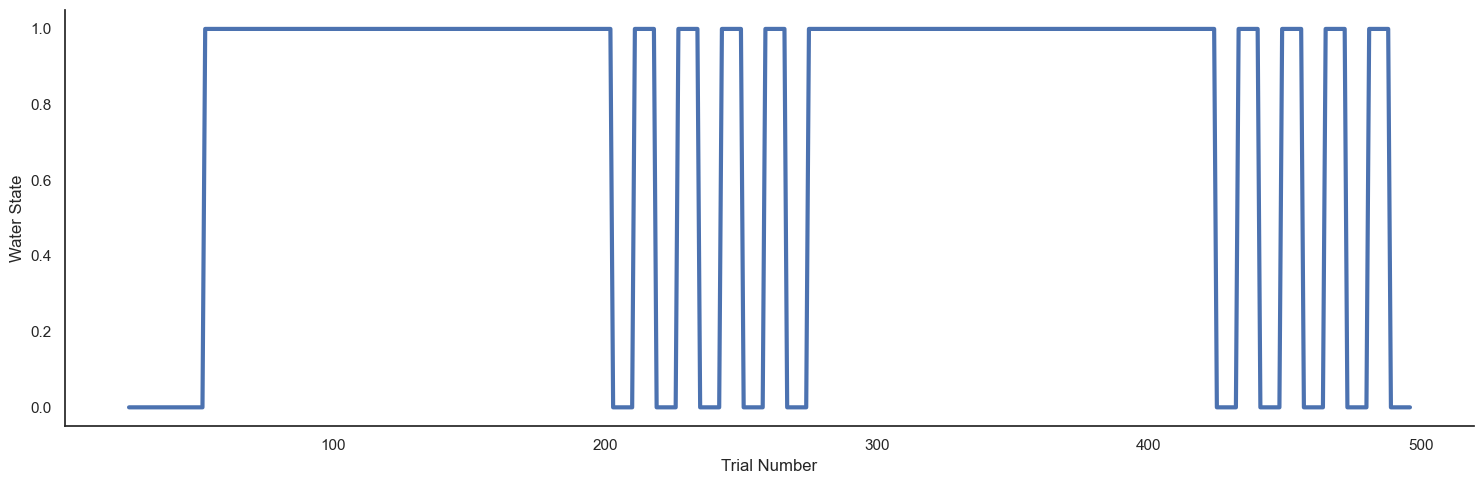

In [423]:
from src.plotting import plot_trial_schedule

# trial schedule plot
g = plot_trial_schedule(df_small, context='poster', font_scale=3)


In [177]:
from src.features import point_of_crossing_x

df_small['error_x_plane'] = df_small.apply(point_of_crossing_x, axis=1)
df_small_filt['error_x_plane'] = df_small.apply(point_of_crossing_x, axis=1)


In [559]:
# number of participants
from src.features import N_by_set_order

N_by_set_order(df_small)

Number of Participants in data: 38
20 ppid in set order 1
18 ppid in set order 2


C:\Users\jacob\water_current_MA\src\features.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = np.array(data.groupby('set_order')['ppid'].nunique().reset_index())


### BASELINE

In [17]:
from src.features import summarize_phase
baseline = summarize_phase(df_small, phase='baseline')

baseline_filt = summarize_phase(df_small_filt, phase='baseline')

baseline

ppid target_x_label  mean_ball_dist_cm  min_ball_dist_cm  \
0    p000         neg0.3          23.057209          6.355549   
1    p000         neg0.6          15.812623          6.475343   
2    p000           p0.3          41.414935          6.031173   
3    p000           p0.6          11.139143          6.613340   
4    p003         neg0.3          16.001942          7.253315   
..    ...            ...                ...               ...   
147  p050           p0.6          16.351695          6.180133   
148  p051         neg0.3          16.647904          7.361469   
149  p051         neg0.6          11.637518          7.757881   
150  p051           p0.3          10.670697          6.976257   
151  p051           p0.6          12.376480          6.941832   

     mean_ball_dist_x_cm  mean_ball_launch_dev  mean_ball_launch_speed  
0              16.687057             -6.468969                1.504982  
1               9.813686             -2.971365                1.885979  
2              26.899357            -15.431637                1.653630  
3               2.874871             -1.944168                1.987985  
4               7.173171             -2.715127                1.451527  
..                   ...                   ...                     ...  
147            12.669257             -5.857698                2.070455  
148             8.286714             -2.976653                0.836755  
149            -6.316286              3.240752                0.979233  
150             3.228657             -1.906476                1.043052  
151            -7.609500              2.081311                1.177750  

[152 rows x 7 columns]

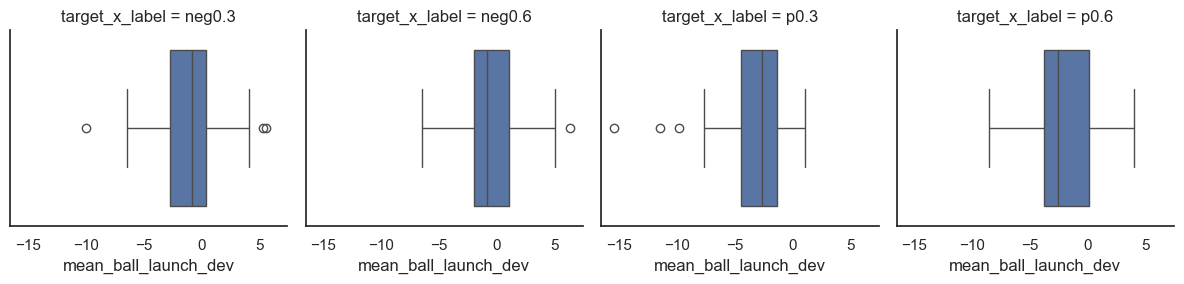

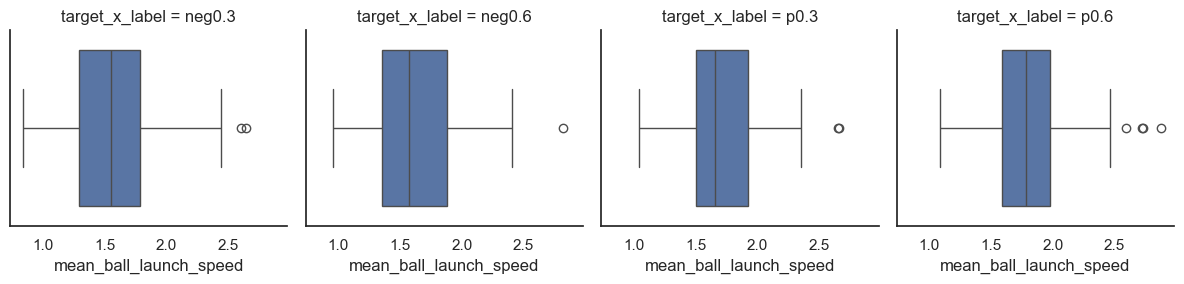

                             OLS Regression Results                             
Dep. Variable:     mean_ball_launch_dev   R-squared:                       0.127
Model:                              OLS   Adj. R-squared:                  0.109
Method:                   Least Squares   F-statistic:                     5.865
Date:                  Tue, 11 Nov 2025   Prob (F-statistic):            0.00221
Time:                          15:12:03   Log-Likelihood:                -382.29
No. Observations:                   152   AIC:                             772.6
Df Residuals:                       148   BIC:                             784.7
Df Model:                             3                                         
Covariance Type:                cluster                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------

In [565]:
from src.plotting import plot_boxplot_target_error
plot_boxplot_target_error(baseline, measure='mean_ball_launch_dev')


plot_boxplot_target_error(baseline, measure='mean_ball_launch_speed')


mod_base_dev = smf.ols("mean_ball_launch_dev ~  C(target_x_label)",
                  data=baseline).fit(
    cov_type="cluster", cov_kwds={"groups": baseline["ppid"]}
)
print(mod_base_dev.summary())


In [235]:
baseline

ppid target_x_label  mean_ball_dist_cm  min_ball_dist_cm  \
0       1         neg0.3          12.435891          6.576384   
1       1         neg0.6          15.217325          6.855369   
2       1           p0.3          10.967290          6.052804   
3       1           p0.6          13.898094          6.206768   
4    p002         neg0.3          14.016409          6.405722   
..    ...            ...                ...               ...   
175  p049           p0.6          11.536559          7.263707   
176  p050         neg0.3          18.870366          6.322654   
177  p050         neg0.6          21.281994          9.833997   
178  p050           p0.3          22.556511          7.676893   
179  p050           p0.6          22.272908          5.923408   

     mean_ball_dist_x_cm  mean_ball_launch_dev  mean_ball_launch_speed  
0               4.654983             -1.407555                1.717149  
1               0.651536              0.658937                1.640399  
2               6.301708             -3.132684                2.135128  
3               8.571118             -4.097248                2.048416  
4              13.594155             -5.278668                1.939574  
..                   ...                   ...                     ...  
175             0.029309             -0.699814                1.317727  
176            10.789058             -4.083450                1.719524  
177             3.893927             -0.902069                1.905100  
178            12.169275             -5.538298                1.539462  
179            10.156745             -5.087802                1.618435  

[180 rows x 7 columns]

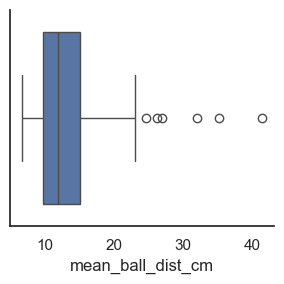

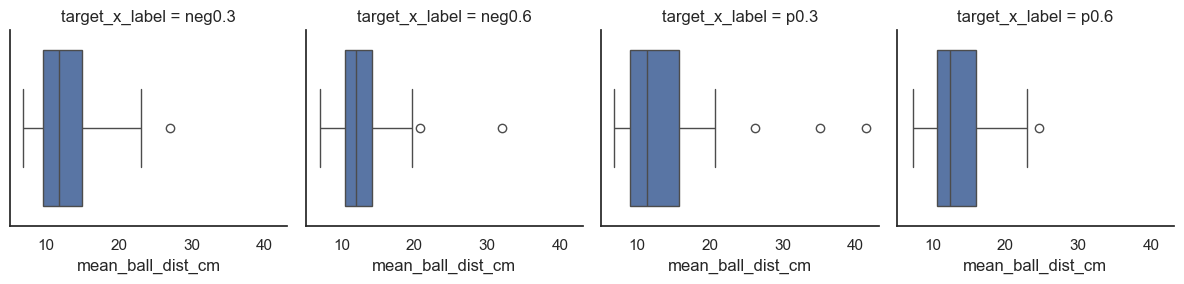

In [400]:
plot_boxplot_target_error(baseline, measure='mean_ball_dist_cm', facet_by_target=False)
plot_boxplot_target_error(baseline, measure='mean_ball_dist_cm')

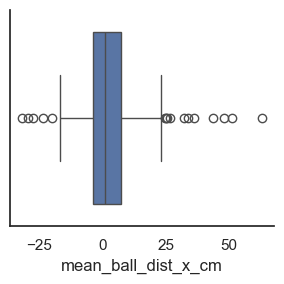

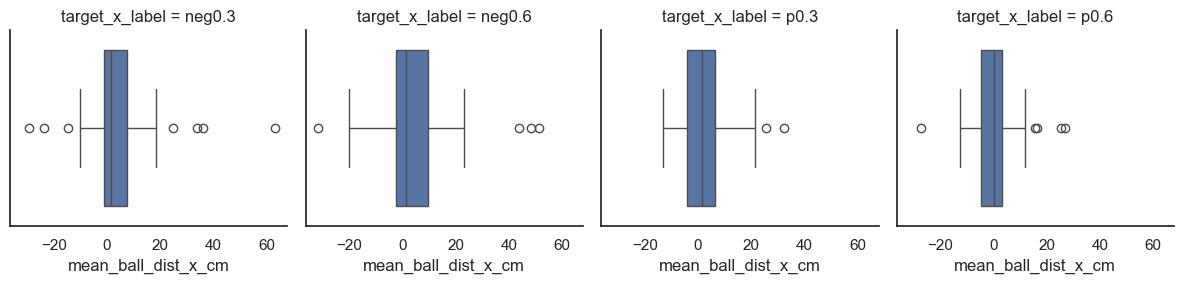

In [96]:
plot_boxplot_target_error(baseline, measure='mean_ball_dist_x_cm', facet_by_target=False)
plot_boxplot_target_error(baseline, measure='mean_ball_dist_x_cm')

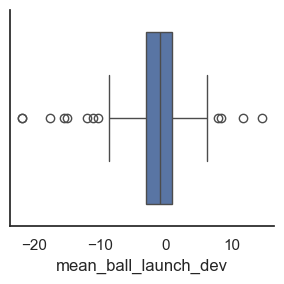

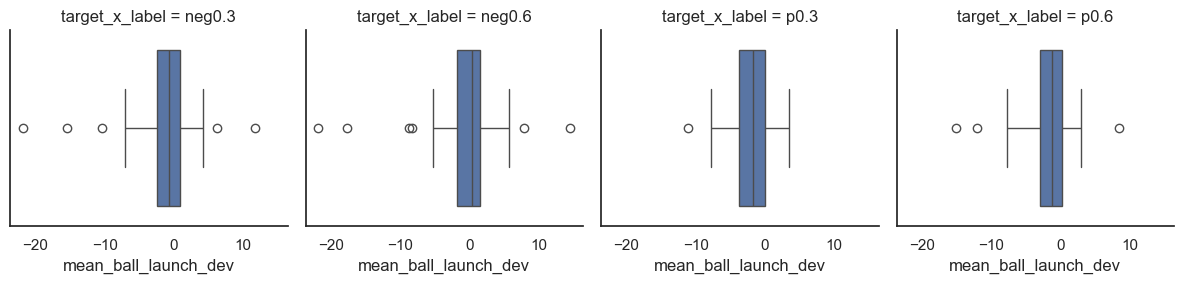

In [277]:
plot_boxplot_target_error(baseline, measure='mean_ball_launch_dev', facet_by_target=False)
plot_boxplot_target_error(baseline, measure='mean_ball_launch_dev')

### BASELINE CORRECTED MIN DISTANCE: maybe make a function to loop through cols?

In [739]:
# combine baseline error back to main df
df_BC = df_small.merge(baseline, on=['ppid', 'target_x_label'], how='left')

df_filt_BC = df_small_filt.merge(baseline_filt, on=['ppid', 'target_x_label'], how='left')


# baseline correct min distance 
df_BC['baseline_corrected_dist'] = df_BC['ball_dist_to_center_cm'] - df_BC['mean_ball_dist_cm']
# baseline corrected error x plane
df_BC['baseline_corrected_x'] = df_BC['error_x_plane'] - df_BC['mean_ball_dist_x_cm']
# baseline corrected launch dev
df_BC['baseline_corrected_dev'] = df_BC['launch_deviation'] - df_BC['mean_ball_launch_dev']
# baseline corrected launch speed
df_BC['baseline_corrected_speed'] = df_BC['launch_Speed'] - df_BC['mean_ball_launch_speed']


# filtered data baseline correct
df_filt_BC['baseline_corrected_dist'] = df_filt_BC['ball_dist_to_center_cm'] - df_filt_BC['mean_ball_dist_cm']
# baseline corrected error x plane
df_filt_BC['baseline_corrected_x'] = df_filt_BC['error_x_plane'] - df_filt_BC['mean_ball_dist_x_cm']
# baseline corrected launch dev
df_filt_BC['baseline_corrected_dev'] = df_filt_BC['launch_deviation'] - df_filt_BC['mean_ball_launch_dev']
# baseline corrected launch speed
df_filt_BC['baseline_corrected_speed'] = df_filt_BC['launch_Speed'] - df_filt_BC['mean_ball_launch_speed']


In [741]:
baseline_filt

ppid target_x_label  mean_ball_dist_cm  min_ball_dist_cm  \
0    p000         neg0.3          23.057209          6.355549   
1    p000         neg0.6          15.812623          6.475343   
2    p000           p0.3          19.298343          6.031173   
3    p000           p0.6          11.139143          6.613340   
4    p003         neg0.3          16.001942          7.253315   
..    ...            ...                ...               ...   
147  p050           p0.6          16.351695          6.180133   
148  p051         neg0.3          16.647904          7.361469   
149  p051         neg0.6          11.637518          7.757881   
150  p051           p0.3          10.670697          6.976257   
151  p051           p0.6          12.376480          6.941832   

     mean_ball_dist_x_cm  mean_ball_launch_dev  mean_ball_launch_speed  
0              16.687057             -6.468969                1.504982  
1               9.813686             -2.971365                1.885979  
2              12.630350             -5.582283                1.754842  
3               2.874871             -1.944168                1.987985  
4               7.173171             -2.715127                1.451527  
..                   ...                   ...                     ...  
147            12.669257             -5.857698                2.070455  
148             8.286714             -2.976653                0.836755  
149            -6.316286              3.240752                0.979233  
150             3.228657             -1.906476                1.043052  
151            -7.609500              2.081311                1.177750  

[152 rows x 7 columns]

In [69]:
df_BC

ppid  trial_num      phase  trial_num_target  launch_deviation  \
0         1          1   baseline                 1         -1.155891   
1         1          2   baseline                 1         -9.285237   
2         1          3   baseline                 1         -5.433519   
3         1          4   baseline                 1         -7.419443   
4         1          5   baseline                 2         -6.313191   
...     ...        ...        ...               ...               ...   
22315  p050        492  washout_2               122          5.273447   
22316  p050        493  washout_2               123         -1.938383   
22317  p050        494  washout_2               123         -2.213391   
22318  p050        495  washout_2               124          3.030887   
22319  p050        496  washout_2               124        -15.191531   

       launch_Speed  ball_dist_to_center_cm target_hit  water_speed_binary  \
0          2.877647                6.025467       True                   0   
1          3.028949               23.203476      False                   0   
2          3.173107               14.747873      False                   0   
3          1.929576               18.619847      False                   0   
4          2.426742               17.174473      False                   0   
...             ...                     ...        ...                 ...   
22315      4.112829               13.375844      False                   0   
22316      4.617405                5.145460       True                   0   
22317      2.782864                7.337979       True                   0   
22318      3.364877                7.570455       True                   0   
22319      4.120431               39.955590      False                   0   

       water_speed_m_s  ... error_x_plane mean_ball_dist_cm min_ball_dist_cm  \
0                  0.0  ...        6.4524         14.660809         6.025467   
1                  0.0  ...       23.1997         13.264166         6.576384   
2                  0.0  ...       11.8783         14.060765         6.206768   
3                  0.0  ...       17.1628         11.555948         6.052804   
4                  0.0  ...       18.2091         14.660809         6.025467   
...                ...  ...           ...               ...              ...   
22315              0.0  ...      -13.5430         29.671025         7.676893   
22316              0.0  ...        2.4980         29.671025         7.676893   
22317              0.0  ...        8.0769         21.850044         9.833997   
22318              0.0  ...       -8.3097         29.671025         7.676893   
22319              0.0  ...       40.6732         21.850044         9.833997   

      mean_ball_dist_x_cm mean_ball_launch_dev mean_ball_launch_speed  \
0                2.448338            -0.016983               1.796060   
1                6.081500            -2.013530               1.818056   
2                6.935623            -3.445993               2.200281   
3                7.137177            -3.462434               2.119316   
4                2.448338            -0.016983               1.796060   
...                   ...                  ...                    ...   
22315           18.272869            -8.702058               1.609071   
22316           18.272869            -8.702058               1.609071   
22317            7.250223            -2.207187               1.991104   
22318           18.272869            -8.702058               1.609071   
22319            7.250223            -2.207187               1.991104   

       baseline_corrected_dist  baseline_corrected_x  baseline_corrected_dev  \
0                    -8.635341              4.004062               -1.138908   
1                     9.939310             17.118200               -7.271707   
2                     0.687108              4.942677               -1.987526   
3                     7.063899     

In [404]:
df_filt_BC

ppid  trial_num      phase  trial_num_target  launch_deviation  \
0      p000         25   baseline                 7         -2.379829   
1      p000         26   baseline                 7        -29.354557   
2      p000         27   baseline                 7          2.430909   
3      p000         28   baseline                 7         -4.166943   
4      p000         29   baseline                 8          0.802309   
...     ...        ...        ...               ...               ...   
19713  p051        492  washout_2               122          0.533717   
19714  p051        493  washout_2               123          3.459009   
19715  p051        494  washout_2               123          1.850777   
19716  p051        495  washout_2               124         -1.210291   
19717  p051        496  washout_2               124         -2.276363   

       launch_Speed  ball_dist_to_center_cm target_hit  water_speed_binary  \
0          1.969417                7.400935       True                   0   
1          1.142749               72.955993      False                   0   
2          1.657019                7.689598       True                   0   
3          1.738741               10.719322      False                   0   
4          1.753271                7.250720       True                   0   
...             ...                     ...        ...                 ...   
19713      1.586906                6.533001       True                   0   
19714      1.532940                9.362383      False                   0   
19715      1.591908                6.931768       True                   0   
19716      1.635215                6.535500       True                   0   
19717      1.705489                7.047184       True                   0   

       water_speed_m_s  ... error_x_plane mean_ball_dist_cm min_ball_dist_cm  \
0                  0.0  ...        2.7510         11.139143         6.613340   
1                  0.0  ...       72.4099         23.057209         6.355549   
2                  0.0  ...       -2.9294         15.812623         6.475343   
3                  0.0  ...        9.9595         19.298343         6.031173   
4                  0.0  ...        1.9703         15.812623         6.475343   
...                ...  ...           ...               ...              ...   
19713              0.0  ...       -3.0987         10.670697         6.976257   
19714              0.0  ...       -7.9968         11.637518         7.757881   
19715              0.0  ...       -5.9206         10.670697         6.976257   
19716              0.0  ...        6.0517         11.637518         7.757881   
19717              0.0  ...        3.8033         10.670697         6.976257   

      mean_ball_dist_x_cm mean_ball_launch_dev mean_ball_launch_speed  \
0                2.874871            -1.944168               1.987985   
1               16.687057            -6.468969               1.504982   
2                9.813686            -2.971365               1.885979   
3               12.630350            -5.582283               1.754842   
4                9.813686            -2.971365               1.885979   
...                   ...                  ...                    ...   
19713            3.228657            -1.906476               1.043052   
19714           -6.316286             3.240752               0.979233   
19715            3.228657            -1.906476               1.043052   
19716           -6.316286             3.240752               0.979233   
19717            3.228657            -1.906476               1.043052   

       baseline_corrected_dist  baseline_corrected_x  baseline_corrected_dev  \
0                    -3.738208             -0.123871               -0.435661   
1                    49.898783             55.722843              -22.885589   
2                    -8.123026            -12.743086                5.402274   
3                    -8.579021     

In [198]:
df_filt_BC['trial_num'].min()

25

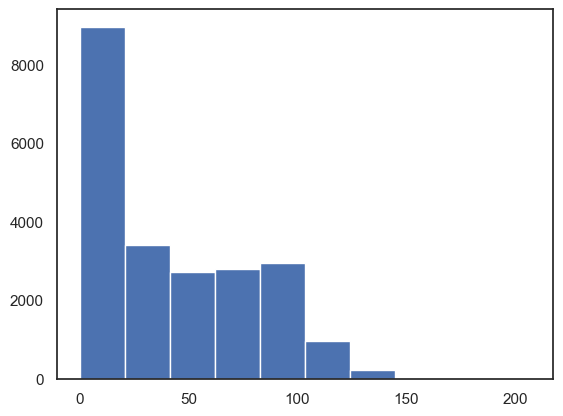

In [137]:
plt.hist(df_filt_BC['ball_dist_to_center_cm'])
plt.show()

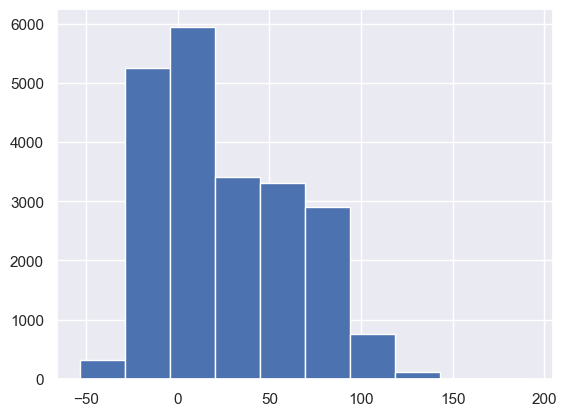

In [79]:
plt.hist(df_filt_BC['baseline_corrected_dist'])
plt.show()

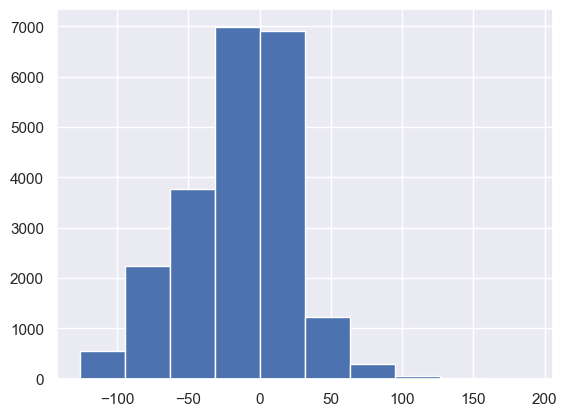

In [87]:
# histogram of baseline errors
plt.hist(df_filt_BC['baseline_corrected_x'])
plt.show()

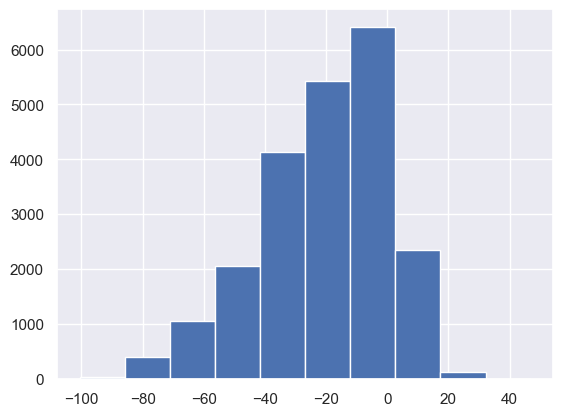

In [89]:
# histogram of baseline errors
plt.hist(df_filt_BC['baseline_corrected_dev'])
plt.show()

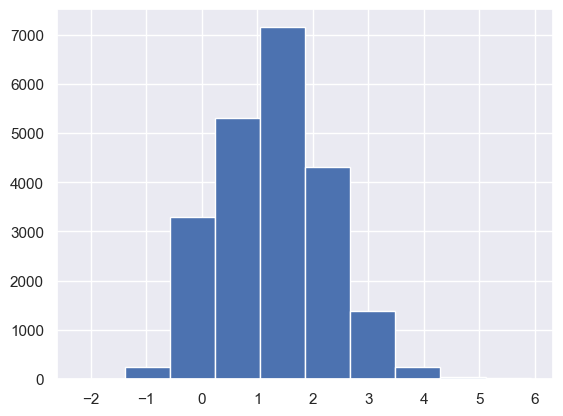

In [91]:
# histogram of baseline errors
plt.hist(df_filt_BC['baseline_corrected_speed'])
plt.show()

In [53]:
baseline

ppid target_x_label  mean_ball_dist_cm  min_ball_dist_cm  \
0    p000         neg0.3          23.057209          6.355549   
1    p000         neg0.6          15.812623          6.475343   
2    p000           p0.3          41.414935          6.031173   
3    p000           p0.6          11.139143          6.613340   
4    p002         neg0.3          13.433998          6.952707   
..    ...            ...                ...               ...   
167  p050           p0.6          15.678087          5.923408   
168  p051         neg0.3          16.647904          7.361469   
169  p051         neg0.6          11.637518          7.757881   
170  p051           p0.3          10.670697          6.976257   
171  p051           p0.6          12.376480          6.941832   

     mean_ball_dist_x_cm  mean_ball_launch_dev  mean_ball_launch_speed  
0              16.687057             -6.468969                1.504982  
1               9.813686             -2.971365                1.885979  
2              26.899357            -15.431637                1.653630  
3               2.874871             -1.944168                1.987985  
4              12.996686             -5.037991                2.078754  
..                   ...                   ...                     ...  
167            -0.366171             -0.728174                2.034437  
168             8.286714             -2.976653                0.836755  
169            -6.316286              3.240752                0.979233  
170             3.228657             -1.906476                1.043052  
171            -7.609500              2.081311                1.177750  

[172 rows x 7 columns]

C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, unit_data in sub_data.groupby("units"):
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, unit_data in sub_data.groupby("units"):
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silenc

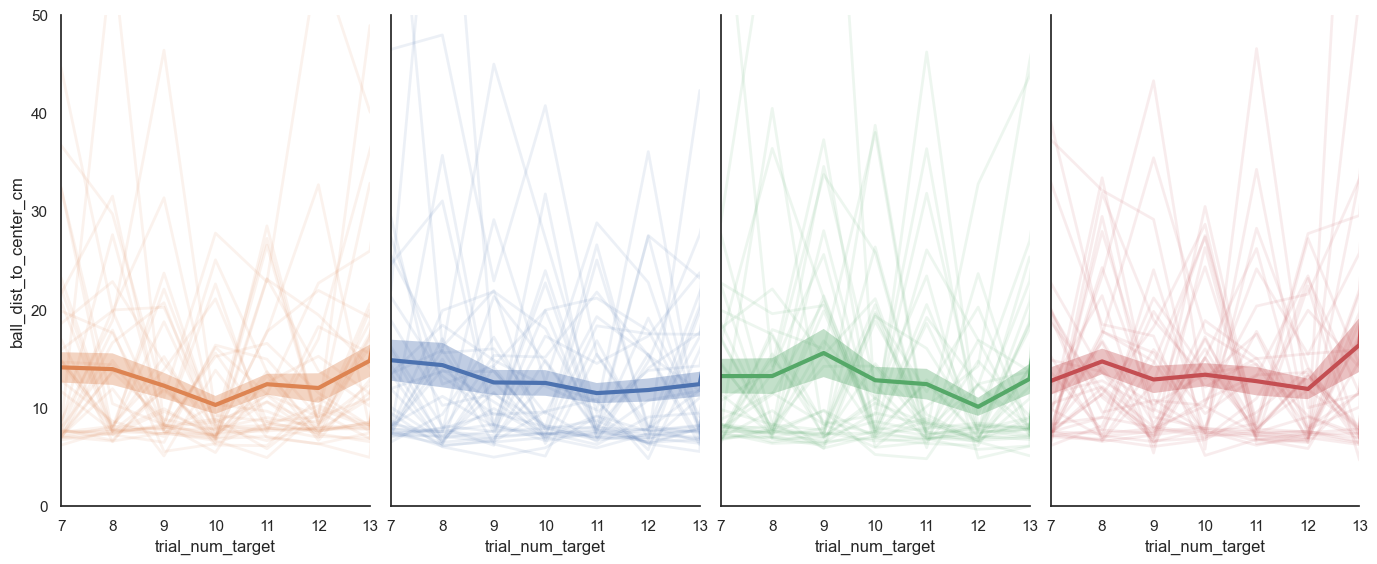

In [569]:
# baseline error plot: 8.75 is likely min
from src.plotting import plot_baseline

plot_baseline(df_filt_BC, context='poster', font_scale=3)

#plot_baseline(df_small, y_col='launch_deviation', y_lim=(-30,30))

#plot_baseline(df_small, y_col='launch_Speed', y_lim=(0.0,4.0))

In [327]:
df_filt_BC['trial_num'].min()

25

In [ ]:
# boxplot for last half of baseline, check for outliers, four boxplots
# dvs: min distance, lateral error, 
# each ppid is represented once

# plot with

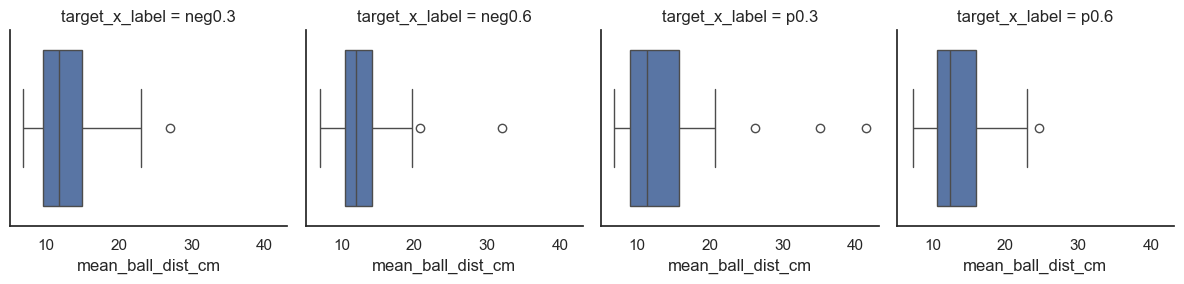

In [410]:
plot_boxplot_target_error(baseline, measure='mean_ball_dist_cm')


In [283]:
ppid_means = (
    baseline
    .groupby(['ppid', 'target_x_label'], as_index=False)['mean_ball_dist_cm']
    .mean()
)

ppid_means.query('mean_ball_dist_cm > 50')


C:\Users\jacob\AppData\Local\Temp\ipykernel_13620\2750927178.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['ppid', 'target_x_label'], as_index=False)['mean_ball_dist_cm']


ppid target_x_label  mean_ball_dist_cm
17   p005         neg0.6          55.073916
25   p007         neg0.6          50.131061
160  p046         neg0.3          59.725014

### EXPOSURE - Early to Late: Update function to allow accepting a list of variables to agg?

In [743]:
from src.early_late_exposure import early_late_means

early_late_4_means_euc = early_late_means(
                                            df_filt_BC,
                                            error_col='baseline_corrected_dist',
                                            window_size=4
                                            )
early_late_4_means_euc

C:\Users\jacob\water_current_MA\src\early_late_exposure.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['ppid','phase','target_x_label'])
C:\Users\jacob\water_current_MA\src\early_late_exposure.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['ppid','target_x_label','phase'], group_keys=False))
C:\Users\jacob\water_current_MA\src\early_late_exposure.py:55: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this w

ppid section target_x_label set_order       phase  mean_dist  \
0    p000   early         neg0.3         1  training_2  32.132650   
1    p000   early         neg0.6         1  training_1  26.157932   
2    p000   early           p0.3         1  training_1  48.825281   
3    p000   early           p0.6         1  training_2  88.261606   
4    p000    late         neg0.3         1  training_2  -7.224973   
..    ...     ...            ...       ...         ...        ...   
299  p051   early           p0.6         2  training_1  82.559860   
300  p051    late         neg0.3         2  training_1   8.473843   
301  p051    late         neg0.6         2  training_2  -5.792583   
302  p051    late           p0.3         2  training_2  -3.829318   
303  p051    late           p0.6         2  training_1  47.678618   

        var_dist  n  
0    1361.739720  4  
1     841.052740  4  
2      65.809435  4  
3    4121.397413  4  
4     341.579551  4  
..           ... ..  
299    12.616685  4  
300   479.973899  4  
301     0.369787  4  
302     1.667741  4  
303  3790.059473  4  

[304 rows x 8 columns]

C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, unit_data in sub_data.groupby("units"):
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, unit_data in sub_data.groupby("units"):
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silenc

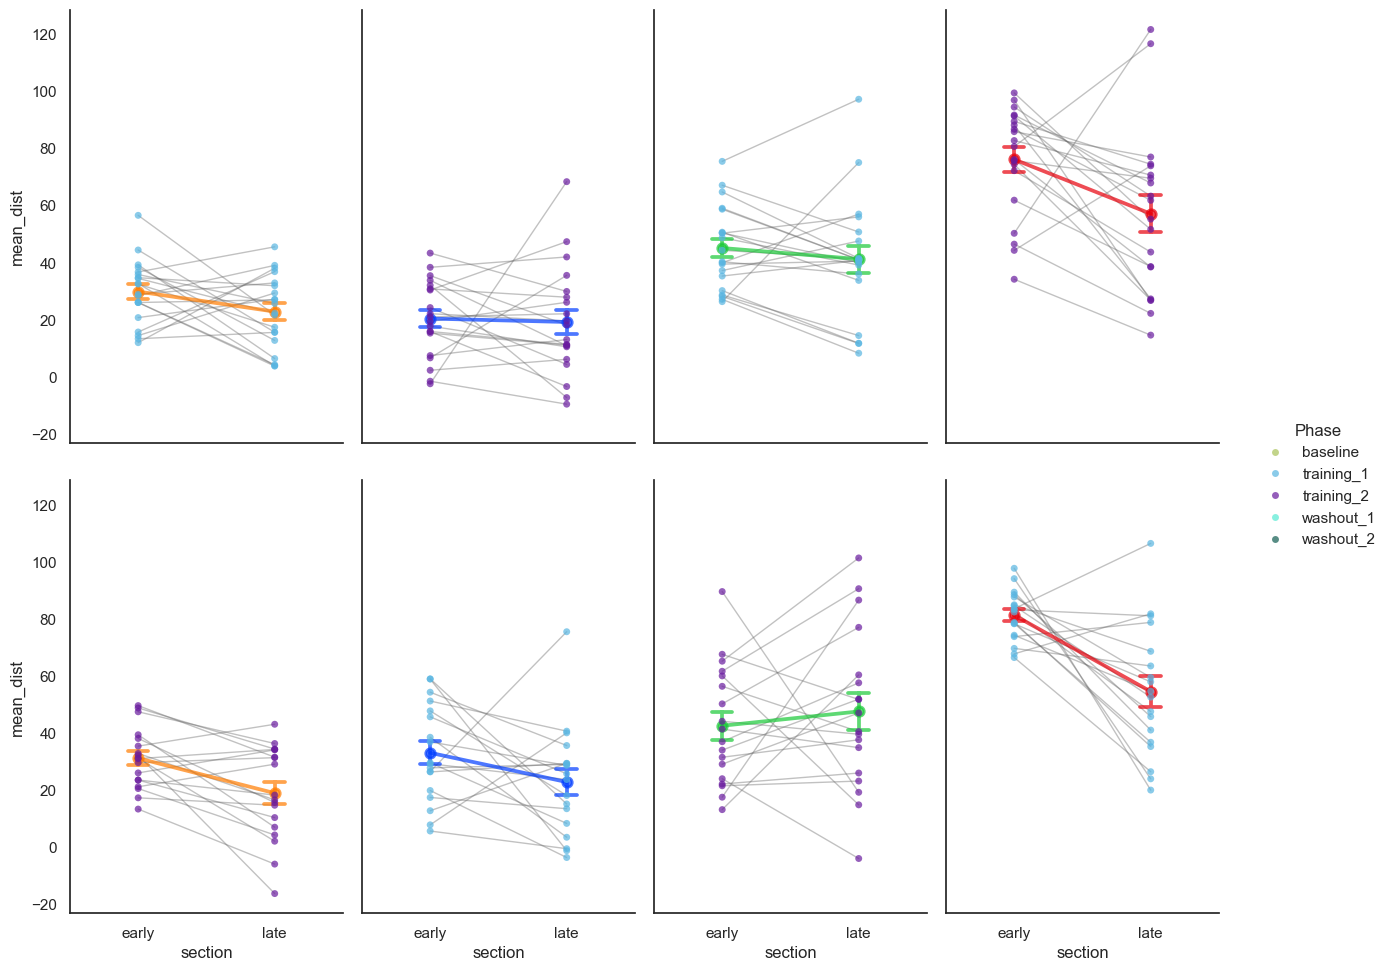

In [573]:
from src.plotting import plot_early_late_exposure

#early_late_4_means['training_status'].unique()


plot_early_late_exposure(early_late_4_means_euc, context='poster', font_scale=3)
#plot_early_late_exposure(early_late_10_means_dev)
#plot_early_late_exposure(early_late_10_means_speed)

C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, unit_data in sub_data.groupby("units"):
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, unit_data in sub_data.groupby("units"):
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silenc

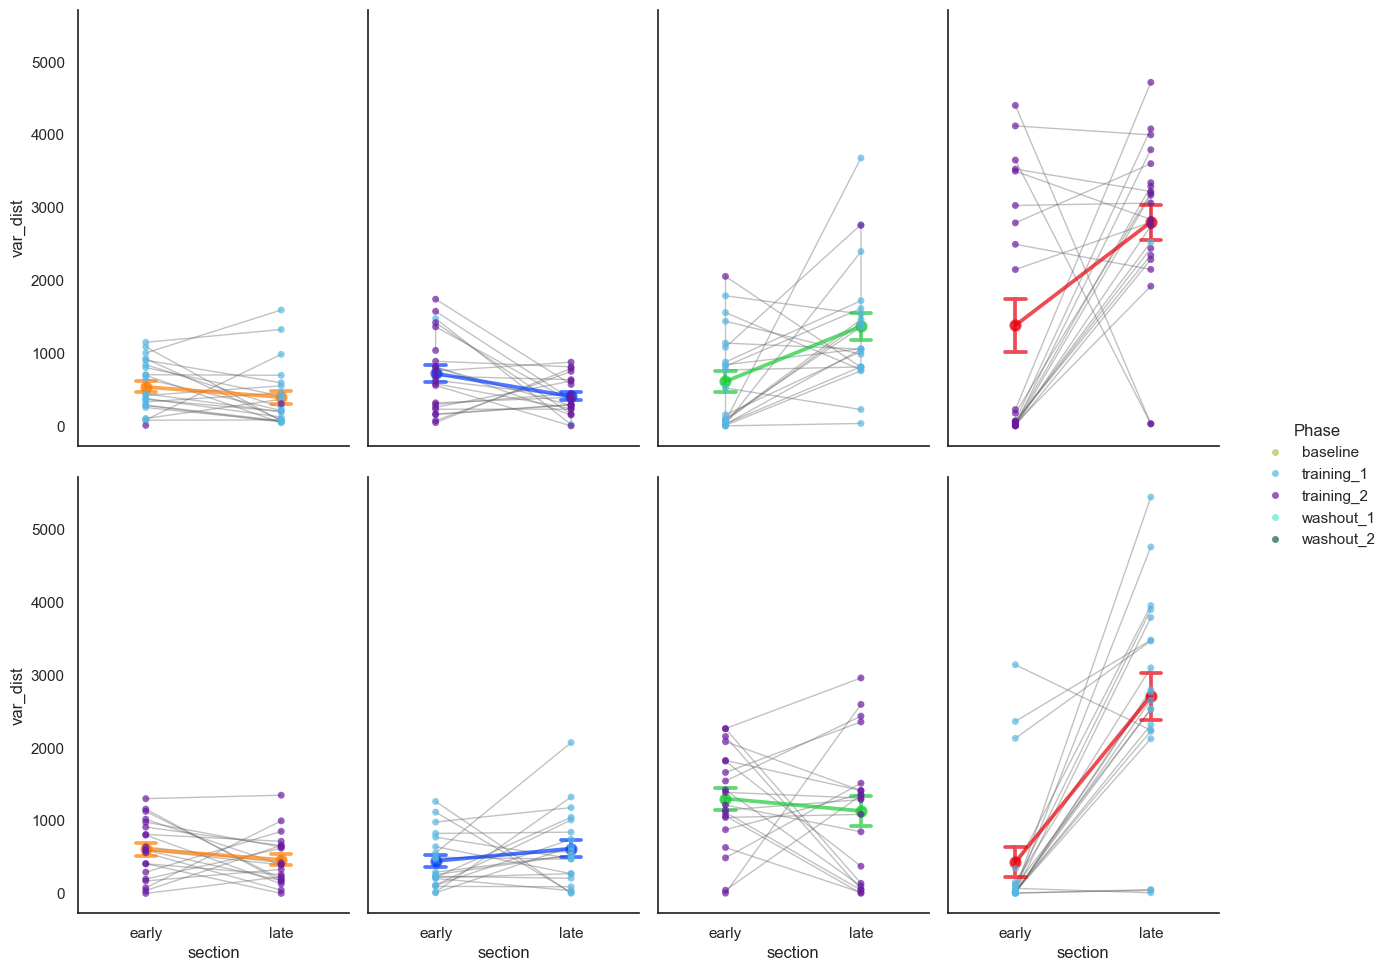

In [418]:
plot_early_late_exposure(early_late_4_means_euc, y_col='var_dist')

In [745]:
# make early_late_10_means_speed using the trained only dataset
early_late_4_means_euc_t1 = early_late_4_means_euc[early_late_4_means_euc['phase'] == 'training_1']

print(early_late_4_means_euc_t1)

# early_late_10_means_trained.to_csv('exposure_early_late_trained.csv', index=False)  
early_late_4_means_euc_t1['n'].max()

     ppid section target_x_label set_order       phase  mean_dist  \
1    p000   early         neg0.6         1  training_1  26.157932   
2    p000   early           p0.3         1  training_1  48.825281   
5    p000    late         neg0.6         1  training_1   4.289273   
6    p000    late           p0.3         1  training_1  39.227206   
9    p003   early         neg0.6         1  training_1  28.985677   
..    ...     ...            ...       ...         ...        ...   
295  p050    late           p0.6         2  training_1  45.901843   
296  p051   early         neg0.3         2  training_1  29.741771   
299  p051   early           p0.6         2  training_1  82.559860   
300  p051    late         neg0.3         2  training_1   8.473843   
303  p051    late           p0.6         2  training_1  47.678618   

        var_dist  n  
1     841.052740  4  
2      65.809435  4  
5     257.596116  4  
6    3680.733667  4  
9     646.728551  4  
..           ... ..  
295  3954.089322 

4

In [149]:
# mixed model (full data)
m = smf.mixedlm("mean_dist ~ section * target_x_label + set_order",
                early_late_4_means_euc,
                groups=early_late_4_means_euc["ppid"])
print(m.fit().summary())


fit = m.fit()

                       Mixed Linear Model Regression Results
Model:                      MixedLM          Dependent Variable:          mean_dist 
No. Observations:           360              Method:                      REML      
No. Groups:                 45               Scale:                       228.2381  
Min. group size:            8                Log-Likelihood:              -1489.0630
Max. group size:            8                Converged:                   Yes       
Mean group size:            8.0                                                     
------------------------------------------------------------------------------------
                                         Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
------------------------------------------------------------------------------------
Intercept                                20.792    2.853  7.287 0.000  15.200 26.384
section[T.late]                          -6.895    3.185 -2.165 0.030 -13.138 -0.653
targ

In [151]:
import statsmodels.formula.api as smf

# ensure 'section' is categorical with levels ['early','late'] (ordered as you intend)
m = smf.mixedlm(
    "mean_dist ~ section * C(target_x_label) + C(set_order)",
    data=early_late_4_means_euc,
    groups=early_late_4_means_euc["ppid"],
    re_formula="~ section"   # random intercept & slope for section
)
res = m.fit(method="lbfgs")
print(res.summary())


                         Mixed Linear Model Regression Results
Model:                       MixedLM           Dependent Variable:           mean_dist 
No. Observations:            360               Method:                       REML      
No. Groups:                  45                Scale:                        228.2143  
Min. group size:             8                 Log-Likelihood:               -1489.0537
Max. group size:             8                 Converged:                    Yes       
Mean group size:             8.0                                                       
---------------------------------------------------------------------------------------
                                            Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
---------------------------------------------------------------------------------------
Intercept                                   20.856    2.895  7.204 0.000  15.182 26.530
section[T.late]                             -6.895    3.1

### ALL EXPOSURE TRIALS

In [747]:
from src.filter_phase import filter_for_phase

training = filter_for_phase(df_filt_BC, phase_key='t', inc_phase=True, expected_n=75)
training_df = training[0]
training_df['trial_num'].min()

C:\Users\jacob\water_current_MA\src\filter_phase.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  if block == True:
C:\Users\jacob\water_current_MA\src\filter_phase.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  )


53

In [335]:
df_filt_BC['phase']

0         baseline
1         baseline
2         baseline
3         baseline
4         baseline
           ...    
20933    washout_2
20934    washout_2
20935    washout_2
20936    washout_2
20937    washout_2
Name: phase, Length: 20938, dtype: category
Categories (5, object): ['baseline', 'training_1', 'training_2', 'washout_1', 'washout_2']

# Solution-space heatmap & GAMs

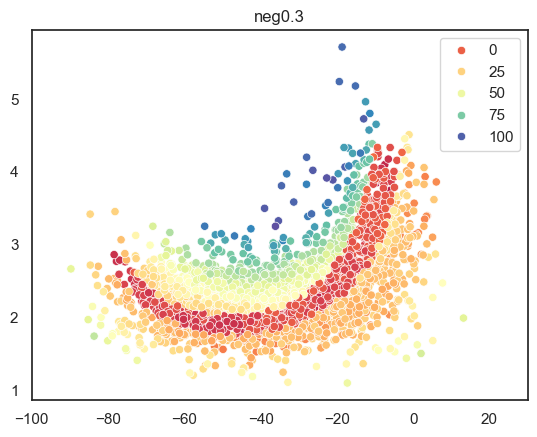

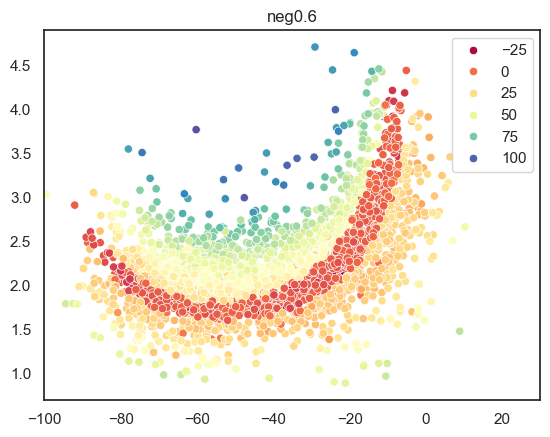

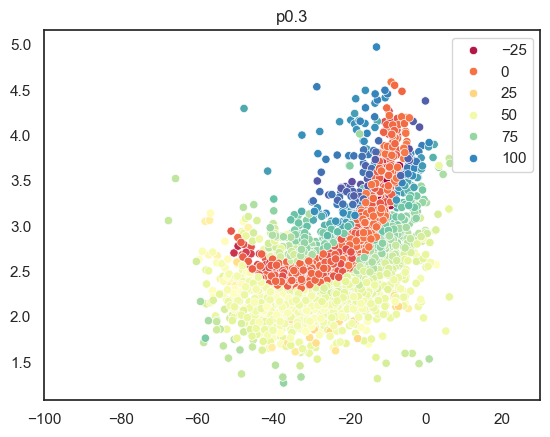

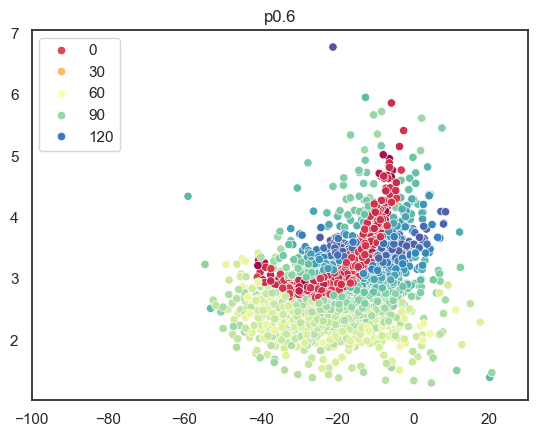

In [751]:
target_labels = np.unique(training_df['target_x_label'])


speeds = np.array(training_df['launch_Speed']) #.reshape(-1,1)
angles = np.array(training_df['launch_deviation'])#.reshape(-1,1)
error = np.array(training_df['baseline_corrected_dist'])#.reshape(-1,1)
targets = np.array(training_df['target_x_label'])#.reshape(-1,1)


for label in target_labels:

    mask = (targets == label)

    errors_masked = error[mask].ravel()

    # launch speeds per target mask
    speeds_masked = speeds[mask].ravel()
         
    # launch deviations per target mask
    angles_masked = angles[mask].ravel()

    plt.figure()
    
    cmap = sns.color_palette("Spectral", as_cmap=True)
    sns.scatterplot(x=angles_masked, y=speeds_masked, hue=errors_masked, palette=cmap)

    plt.xlim(-100,30)

    plt.title(label)
    plt.show()
    

In [755]:
target_labels = np.unique(training_df['target_x_label'])


speeds_z = np.array(training_df['launch_Speed_z']) #.reshape(-1,1)
angles_z = np.array(training_df['launch_dev_z'])#.reshape(-1,1)
error_bc = np.array(training_df['baseline_corrected_dist'])#.reshape(-1,1)
error = np.array(training_df['ball_dist_to_center_cm'])#.reshape(-1,1)
lat_error = np.array(training_df['error_x_plane'])#.reshape(-1,1)

targets = np.array(training_df['target_x_label'])#.reshape(-1,1)


for label in target_labels:

    mask = (targets == label)

    errors_masked = error[mask].ravel()


    # launch speeds per target mask
    speeds_masked = speeds_z[mask].ravel()
    # min
    min_speeds_mask = np.min(speeds_masked)
    # max
    max_speeds_mask = np.max(speeds_masked)
    # range
    range_speeds_mask = max_speeds_mask - min_speeds_mask
    
    # sampled launch speed deviations
    speed_edges = (np.linspace(
                    min_speeds_mask,
                    max_speeds_mask,
                    num=101 # 100 bins
                    )
         )

    print('speed edges:', speed_edges)

    speed_bins = np.digitize(speeds_masked, speed_edges) - 1

         

    # launch deviations per target mask
    angles_masked = angles_z[mask].ravel()
    # min
    min_angles_mask = np.min(angles_masked)
    # max
    max_angles_mask = np.max(angles_masked)
    # range
    range_angles_mask = max_angles_mask - min_angles_mask

    # sampled launch angle deviations
    angle_edges = (np.linspace(
                    min_angles_mask,
                    max_angles_mask,
                    num=101 # 100 bins
                    )
         )
    print('angle edges:', angle_edges)

    angle_bins = np.digitize(angles_masked, angle_edges) - 1
    

    #plt.figure()

    #sns.scatterplot(x=angles_masked, y=speeds_masked, hue=errors_masked)

    #plt.xlim(-100,30)

    #plt.title(label)
    #plt.show()
    

speed edges: [-1.95035869 -1.88335208 -1.81634547 -1.74933886 -1.68233225 -1.61532563
 -1.54831902 -1.48131241 -1.4143058  -1.34729919 -1.28029258 -1.21328597
 -1.14627936 -1.07927275 -1.01226614 -0.94525953 -0.87825291 -0.8112463
 -0.74423969 -0.67723308 -0.61022647 -0.54321986 -0.47621325 -0.40920664
 -0.34220003 -0.27519342 -0.20818681 -0.1411802  -0.07417358 -0.00716697
  0.05983964  0.12684625  0.19385286  0.26085947  0.32786608  0.39487269
  0.4618793   0.52888591  0.59589252  0.66289914  0.72990575  0.79691236
  0.86391897  0.93092558  0.99793219  1.0649388   1.13194541  1.19895202
  1.26595863  1.33296524  1.39997185  1.46697847  1.53398508  1.60099169
  1.6679983   1.73500491  1.80201152  1.86901813  1.93602474  2.00303135
  2.07003796  2.13704457  2.20405119  2.2710578   2.33806441  2.40507102
  2.47207763  2.53908424  2.60609085  2.67309746  2.74010407  2.80711068
  2.87411729  2.9411239   3.00813052  3.07513713  3.14214374  3.20915035
  3.27615696  3.34316357  3.41017018  3

In [667]:
import pygam
import scipy
import progressbar

In [757]:
# ensure angles, speed, and error are flaots
angles_z = np.asarray(angles_z, dtype=float)
speeds_z = np.asarray(speeds_z, dtype=float)
trial_n_z = np.asarray(
error = np.asarray(error, dtype=float)
lat_error = np.asarray(lat_error, dtype=float)
intercept = np.ones(len(error))

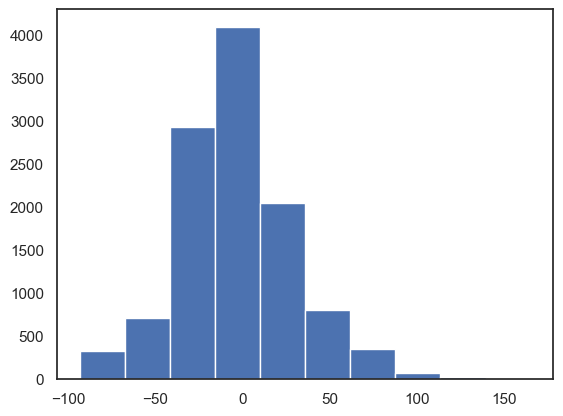

((array([-3.84125604, -3.61779754, -3.49519506, ...,  3.49519506,
          3.61779754,  3.84125604], shape=(11325,)),
  array([-93.2212, -93.1513, -93.1228, ..., 141.2169, 157.4061, 165.119 ],
        shape=(11325,))),
 (np.float64(33.06985351400181),
  np.float64(-2.5598339602649065),
  np.float64(0.9908670097152065)))

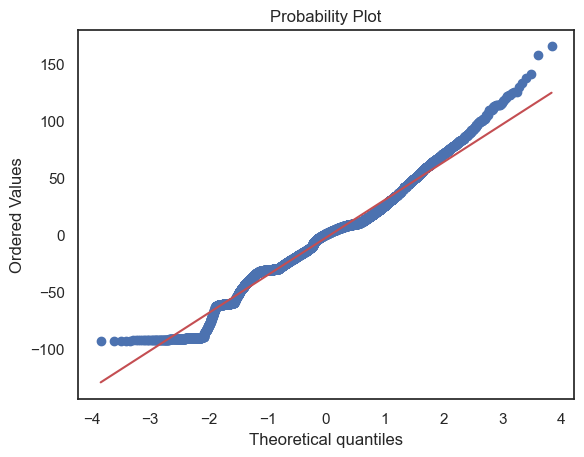

In [707]:
import scipy.stats as stats

plt.hist(lat_error)
plt.show()

stats.probplot(lat_error, dist="norm", plot=plt)


In [709]:
stats.shapiro(lat_error[:5000]) 

ShapiroResult(statistic=np.float64(0.9818867966261505), pvalue=np.float64(8.424234994220266e-25))

In [785]:
tgts = pd.get_dummies(training_df['target_x_label'], prefix='tgt', drop_first=True)


In [793]:
# construct design matrix
X = np.column_stack([angles_z, speeds_z, tgts])
print(X.shape)

Y = lat_error # error
print(Y.shape)

Y_z = (lat_error - lat_error.mean()) / lat_error.std(ddof=0)

(11325, 5)
(11325,)


In [801]:
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

# X: exog matrix with columns like [phase dummies, target dummies, water_speed, angle, speed]
# y: signed lateral error (one participant/segment)
mod = SARIMAX(Y_z, order=(2,0,0), exog=X, trend="c")  # ARX(1)
res = mod.fit(disp=False)
print(res.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                11325
Model:               SARIMAX(2, 0, 0)   Log Likelihood              -10566.485
Date:                Thu, 13 Nov 2025   AIC                          21150.970
Time:                        12:05:26   BIC                          21216.983
Sample:                             0   HQIC                         21173.177
                              - 11325                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0347      0.012      2.992      0.003       0.012       0.057
x1            -0.4361      0.009    -50.586      0.000      -0.453      -0.419
x2             1.0002      0.008    124.574      0.0

In [791]:
res.mle_retvals

{'fopt': np.float64(4.4826460386881495),
 'gopt': array([-4.79252193e-06,  5.35393951e-07,  1.04449782e-07,  1.35251810e-05,
        -7.03517244e-06,  1.61203495e-05, -9.76188019e-06,  1.09645626e-06]),
 'fcalls': 333,
 'warnflag': 0,
 'converged': True,
 'iterations': 34}

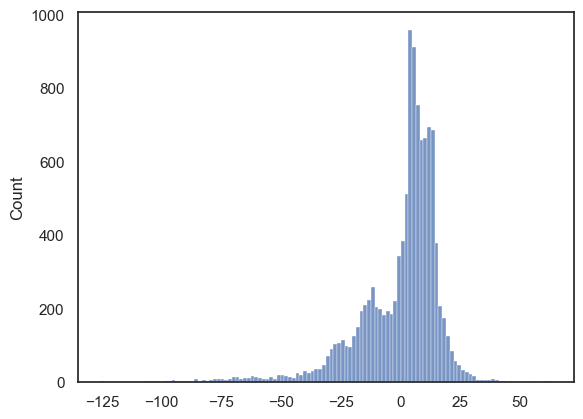

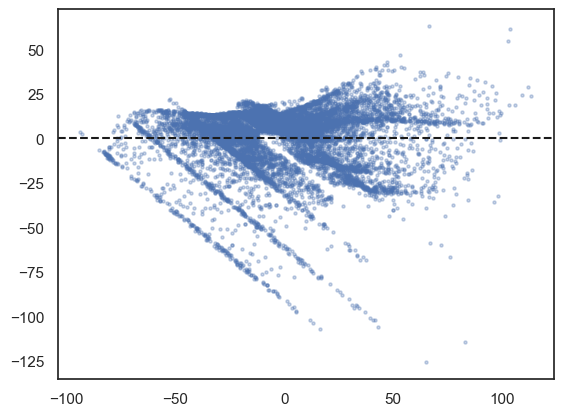

AttributeError: 'TermList' object has no attribute 'n_terms'

In [693]:
# 1) Residual distribution (normality / heavy tails)
sns.histplot(gam.deviance_residuals(X, Y)); plt.show()

# 2) Residuals vs fitted (heteroscedasticity / structure)
resid = gam.deviance_residuals(X, Y)
fitted = gam.predict(X)
plt.scatter(fitted, resid, s=5, alpha=0.3); plt.axhline(0, color='k', ls='--'); plt.show()

# 3) Partial dependence (sanity of smooths)
for i in range(gam.terms.n_terms):
    XX = gam.generate_X_grid(term=i)
    plt.plot(gam.partial_dependence(term=i, X=XX)); plt.title(gam.terms[i]); plt.show()

# 4) Concurvity (collinearity of smooths)
gam.concurvity()


In [581]:
training_df.groupby(['target_x_label', 'ppid'])[['phase_trial_target','trial_num']].max()

C:\Users\jacob\AppData\Local\Temp\ipykernel_13620\177256837.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  training_df.groupby(['target_x_label', 'ppid'])[['phase_trial_target','trial_num']].max()


phase_trial_target  trial_num
target_x_label ppid                               
neg0.3         p000                  74        423
               p003                  73        424
               p004                  74        201
               p005                  75        202
               p006                  73        201
...                                 ...        ...
p0.6           p047                  75        201
               p048                  74        202
               p049                  75        202
               p050                  75        202
               p051                  75        202

[152 rows x 2 columns]

In [583]:
print(training_df['phase_trial_target'].max())

print(
    training_df.groupby(['target_x_label'])['phase_trial_target']
        .max()
)

print(
    training_df.groupby(['target_x_label', 'phase'])['phase_trial_target']
        .max()
)


75
target_x_label
neg0.3    75
neg0.6    75
p0.3      75
p0.6      75
Name: phase_trial_target, dtype: int64
target_x_label  phase     
neg0.3          baseline       NaN
                training_1    75.0
                training_2    75.0
                washout_1      NaN
                washout_2      NaN
neg0.6          baseline       NaN
                training_1    75.0
                training_2    75.0
                washout_1      NaN
                washout_2      NaN
p0.3            baseline       NaN
                training_1    75.0
                training_2    75.0
                washout_1      NaN
                washout_2      NaN
p0.6            baseline       NaN
                training_1    75.0
                training_2    75.0
                washout_1      NaN
                washout_2      NaN
Name: phase_trial_target, dtype: float64


C:\Users\jacob\AppData\Local\Temp\ipykernel_13620\171956076.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  training_df.groupby(['target_x_label'])['phase_trial_target']
C:\Users\jacob\AppData\Local\Temp\ipykernel_13620\171956076.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  training_df.groupby(['target_x_label', 'phase'])['phase_trial_target']


C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, unit_data in sub_data.groupby("units"):
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, unit_data in sub_data.groupby("units"):
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silenc

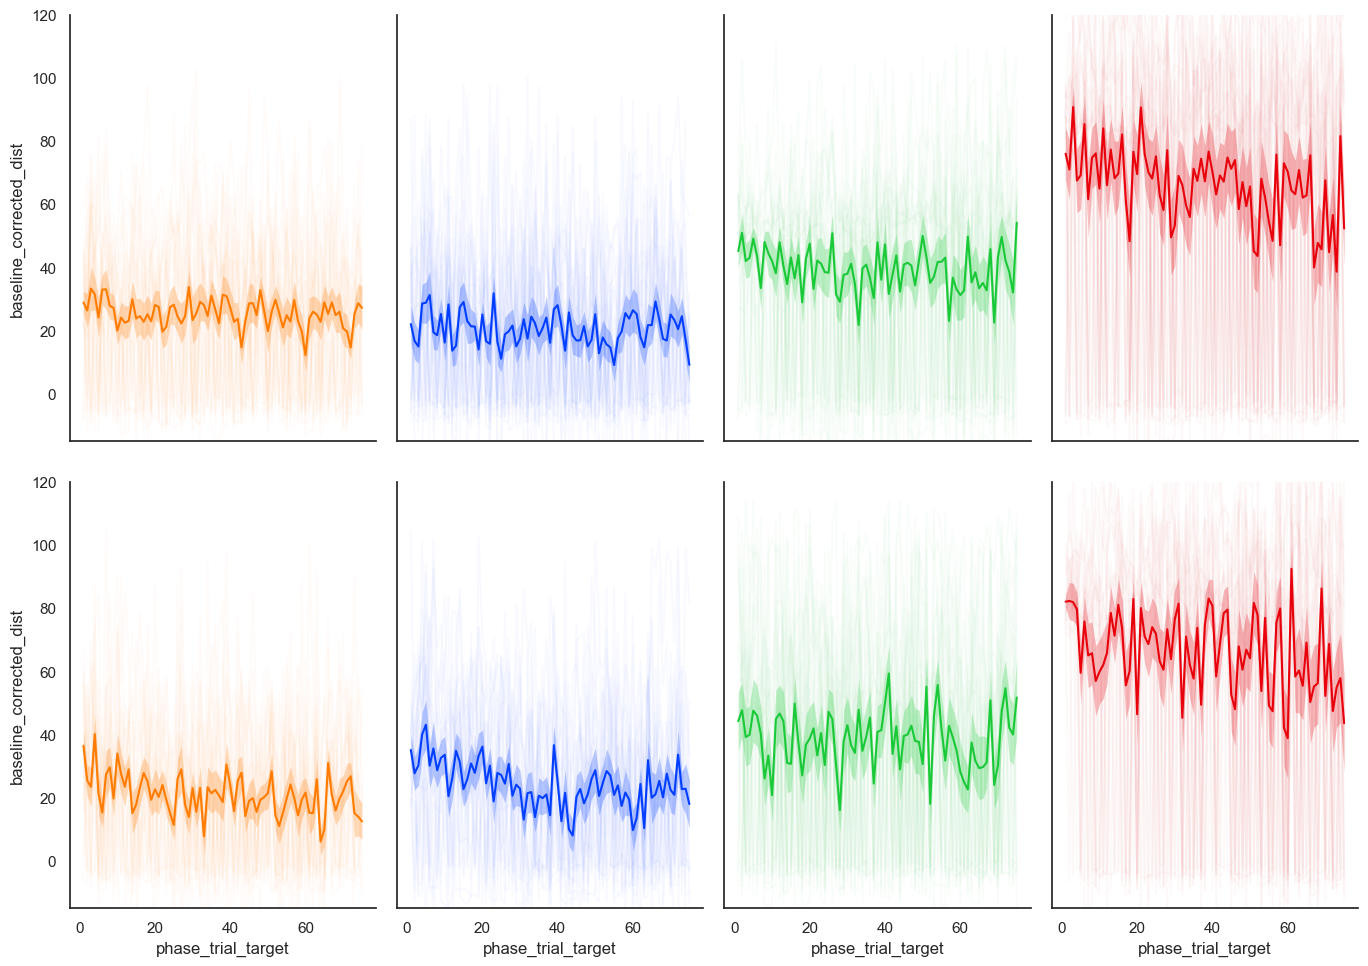

In [585]:
from src.plotting import plot_exposure_trials

plot_exposure_trials(training_df, 
                     y_col = 'baseline_corrected_dist', 
                     context='poster', 
                     font_scale=3, 
                     estimator='mean', 
                     y_lim=(-15,120)
                    )

C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, unit_data in sub_data.groupby("units"):
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, unit_data in sub_data.groupby("units"):
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silenc

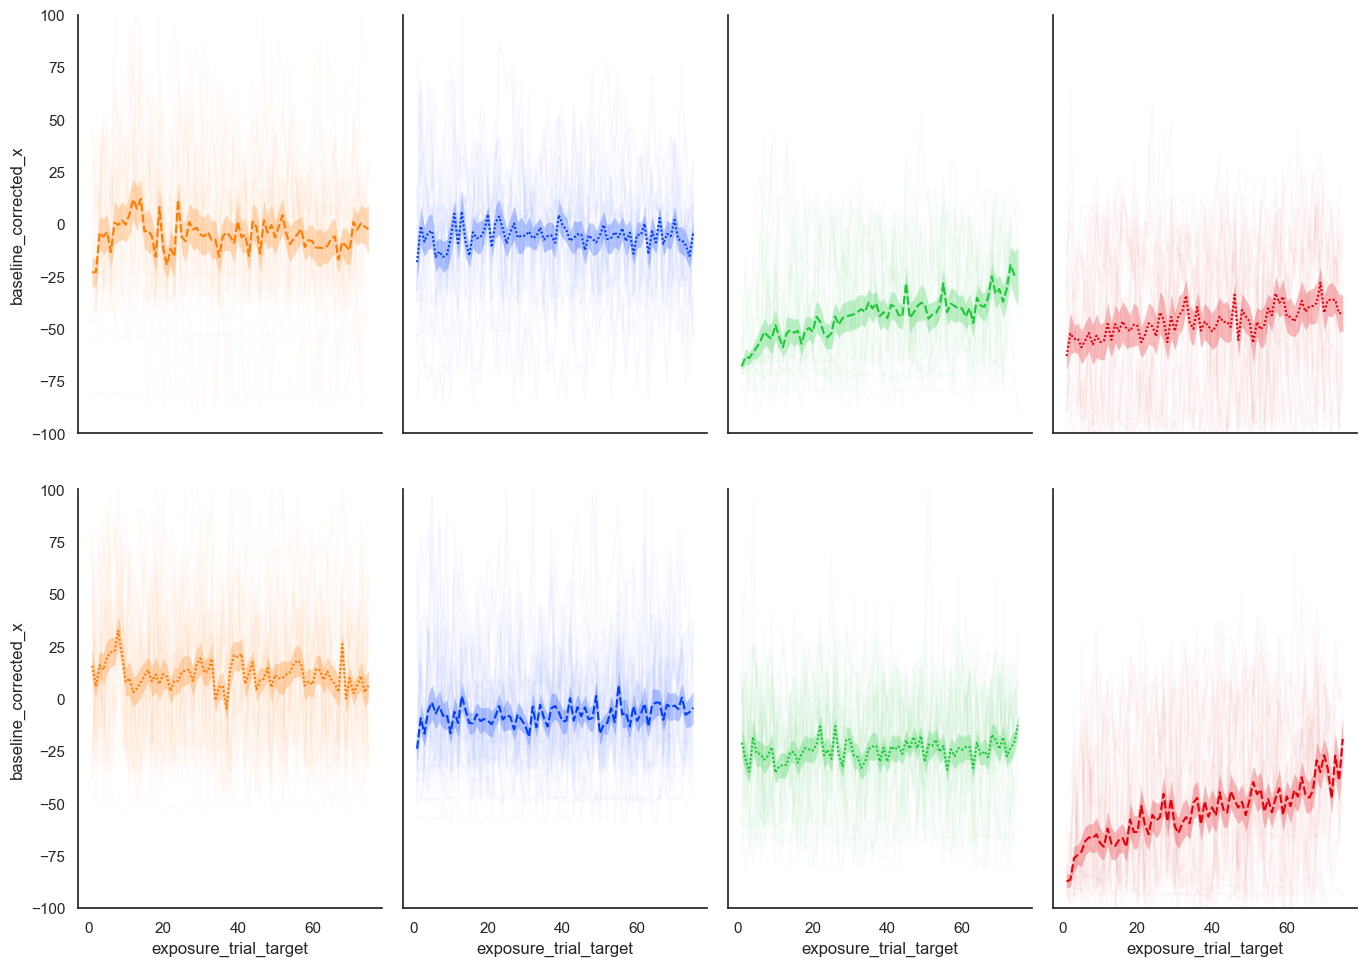

In [247]:

plot_exposure_trials(training, y_col='baseline_corrected_x', y_lim=(-100.0,100.0))

### GENERALIZATION

In [587]:

# makee exposure df with only early trial means
training_gen = early_late_4_means_euc[early_late_4_means_euc['section'] == 'early']

training_gen.head(8)

ppid section target_x_label set_order       phase  mean_dist     var_dist  \
0   p000   early         neg0.3         1  training_2  32.132650  1361.739720   
1   p000   early         neg0.6         1  training_1  26.157932   841.052740   
2   p000   early           p0.3         1  training_1  48.825281    65.809435   
3   p000   early           p0.6         1  training_2  88.261606  4121.397413   
8   p003   early         neg0.3         1  training_2  33.873524   229.915692   
9   p003   early         neg0.6         1  training_1  28.985677   646.728551   
10  p003   early           p0.3         1  training_1  40.392138    82.543202   
11  p003   early           p0.6         1  training_2  75.811196    35.213001   

    n  
0   4  
1   4  
2   4  
3   4  
8   4  
9   4  
10  4  
11  4

In [87]:
# save exposure data to CSV; may not need if we can run R functions here...
training_gen.to_csv('training_gen_f4.csv', index=False)  


C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#4c72b0'` for the same effect.

  func(*plot_args, **plot_kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#4c72b0'` for the same effect.

  func(*plot_args, **plot_kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#4c72b0'` for the same effect.

  func(*plot_args, **plot_kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#4c72b0'` for the same effect.

  func(*pl

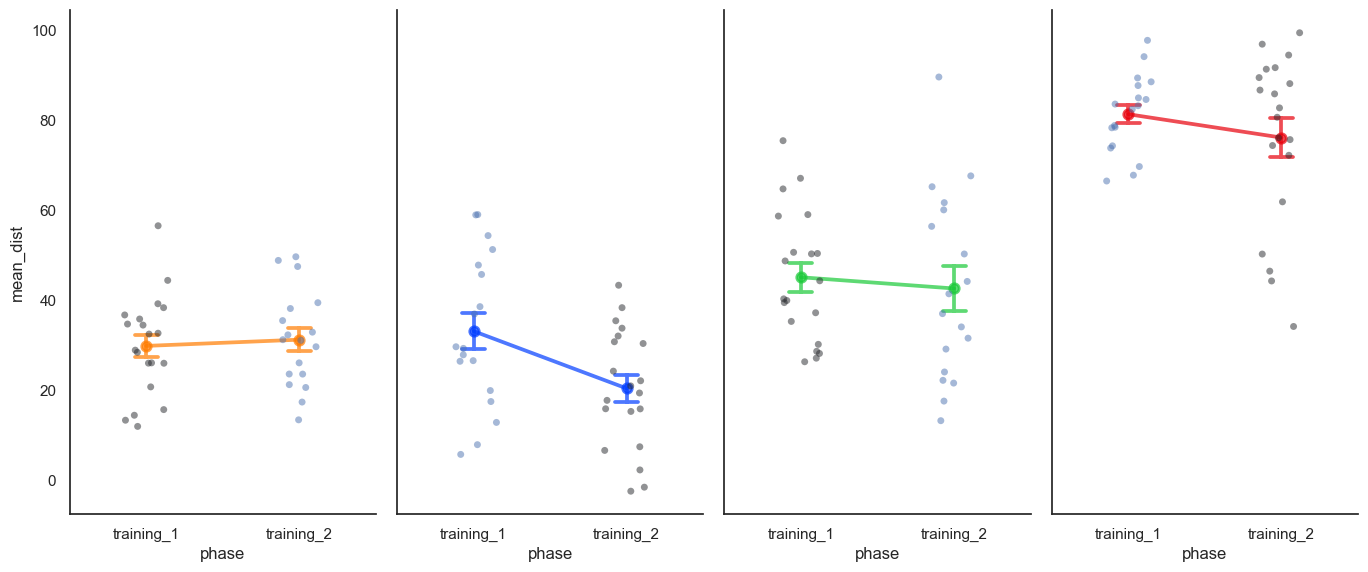

In [589]:
from src.plotting import plot_generalization

plot_generalization(training_gen, context='poster', font_scale=3)

In [345]:
ppid_means = (
    training_gen
    .groupby(['ppid', 'phase', 'target_x_label'], as_index=False)['mean_dist']
    .mean()
)

ppid_means.query('mean_dist < -30')


C:\Users\jacob\AppData\Local\Temp\ipykernel_13620\2037912638.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['ppid', 'phase', 'target_x_label'], as_index=False)['mean_dist']


ppid       phase target_x_label  mean_dist
125  p007  training_1         neg0.6 -35.467465
808  p046  training_2         neg0.3 -33.400393

In [ ]:
### WASHOUT

In [623]:
df_filt_BC.columns

Index(['ppid', 'trial_num', 'phase', 'trial_num_target', 'launch_deviation',
       'launch_Speed', 'ball_dist_to_center_cm', 'target_hit',
       'water_speed_binary', 'water_speed_m_s', 'target_x_label', 'sign_label',
       'set_order', 'ball_pos_x', 'ball_pos_z', 'target_position_x',
       'target_position_z', 'target_angle_90', 'error_x_plane',
       'mean_ball_dist_cm', 'min_ball_dist_cm', 'mean_ball_dist_x_cm',
       'mean_ball_launch_dev', 'mean_ball_launch_speed',
       'baseline_corrected_dist', 'baseline_corrected_x',
       'baseline_corrected_dev', 'baseline_corrected_speed'],
      dtype='object')

In [633]:
from src.filter_phase import filter_for_phase
baseline_washout_dfs = filter_for_phase(df_filt_BC, phase_key=['b','w'], block=True, block_len = 4, inc_phase=False)
baseline_washout_df = baseline_washout_dfs[0]

baseline_washout_df['error_x_plane']


C:\Users\jacob\water_current_MA\src\filter_phase.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  
C:\Users\jacob\water_current_MA\src\filter_phase.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  )


1        72.4099
6        16.3042
9        21.9579
15       -2.2069
18      -15.8835
          ...   
17606     9.4966
17609    -0.1162
17610    -6.7905
17612    -3.6217
17615     2.6440
Name: error_x_plane, Length: 6513, dtype: float64

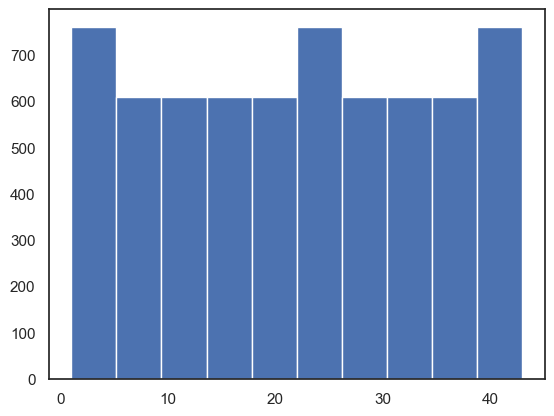

In [595]:
plt.hist(baseline_washout_df['phase_trial_target'])
plt.show()

In [535]:
# find all (ppid, target_x_label) groups with >43 trials
overfilled = (
    baseline_washout_df
    .groupby(['ppid', 'target_x_label'], observed=True)['phase_trial_target']
    .max()
)
overfilled = overfilled[overfilled > 43]
print(overfilled)


ppid  target_x_label
p030  neg0.3            86
      neg0.6            86
      p0.3              86
      p0.6              86
Name: phase_trial_target, dtype: int64


In [617]:
baseline_washout_df

experiment  ppid  session_num  trial_num  block_num  \
25       projectile_experiment   p000            1         26          7   
30       projectile_experiment   p000            1         31          8   
33       projectile_experiment   p000            1         34          9   
39       projectile_experiment   p000            1         40         10   
42       projectile_experiment   p000            1         43         11   
...                         ...   ...          ...        ...        ...   
19608  S2-projectile_experiment  p051            1        265        120   
19611  S2-projectile_experiment  p051            1        268        121   
19612  S2-projectile_experiment  p051            1        269        122   
19614  S2-projectile_experiment  p051            1        271        123   
19617  S2-projectile_experiment  p051            1        274        124   

       trial_num_in_block  start_time   end_time hand target_hit  ...  \
25                      2    215.2137   220.1700    r      False  ...   
30                      3    237.1686   240.8020    r      False  ...   
33                      2    248.4872   252.2879    r      False  ...   
39                      4    271.8066   275.3427    r       True  ...   
42                      3    282.4431   285.9653    r      False  ...   
...                   ...         ...        ...  ...        ...  ...   
19608                   1   1222.0260  1225.8000    r       True  ...   
19611                   2   1233.3870  1236.9370    r       True  ...   
19612                   1   1236.9370  1240.9460    r       True  ...   
19614                   1   1244.8730  1248.7430    r       True  ...   
19617                   2   1256.9850  1260.7720    r       True  ...   

      launch_dev_z launch_Speed_z  set_order  sign_label        side  \
25       -0.333742      -1.893890          1         neg  Downstream   
30        0.759308      -1.205768          1         neg  Downstream   
33        0.648731      -1.566740          1         neg  Downstream   
39        1.151838      -0.359278          1         neg  Downstream   
42        1.388841      -0.503915          1         neg  Downstream   
...            ...            ...        ...         ...         ...   
19608    -0.546826       0.762541          2         pos    Upstream   
19611     1.002002      -1.086277          2         pos    Upstream   
19612     1.132759      -1.207260          2         pos    Upstream   
19614     1.060241      -1.168070          2         pos    Upstream   
19617     0.954827      -1.267429          2         pos    Upstream   

       target_hit_binary trial_num_target target_x_label      phase  \
25                     0                7         neg0.3   baseline   
30                     0                8         neg0.3   baseline   
33                     0                9         neg0.3   baseline   
39                     1               10         neg0.3   baseline   
42                     0               11         neg0.3   baseline   
...                  ...              ...            ...        ...   
19608                  1              120           p0.6  washout_1   
19611                  1              121           p0.6  washout_1   
19612                  1              122           p0.6  washout_1   
19614                  1              123           p0.6  washout_1   
19617                  1              124           p0.6  washout_1   

      phase_trial_target  
25                     1  
30                     2  
33                     3  
39                     4  
42                     5  
...                  ...  
19608                 39  
19611                 40  
19612                 41  
19614                 42  
19617                 43  

[6536 rows x 58 columns]

In [635]:
baseline_washout_df.columns

Index(['ppid', 'trial_num', 'phase', 'trial_num_target', 'launch_deviation',
       'launch_Speed', 'ball_dist_to_center_cm', 'target_hit',
       'water_speed_binary', 'water_speed_m_s', 'target_x_label', 'sign_label',
       'set_order', 'ball_pos_x', 'ball_pos_z', 'target_position_x',
       'target_position_z', 'target_angle_90', 'error_x_plane',
       'mean_ball_dist_cm', 'min_ball_dist_cm', 'mean_ball_dist_x_cm',
       'mean_ball_launch_dev', 'mean_ball_launch_speed',
       'baseline_corrected_dist', 'baseline_corrected_x',
       'baseline_corrected_dev', 'baseline_corrected_speed',
       'phase_trial_target', 'block'],
      dtype='object')

In [293]:
washout_trials[washout_trials.water_speed_binary.ne(washout_trials.water_speed_binary.shift())][[ 'trial_num','washout_trial_target','water_speed_binary',
                                                                                                'target_x_label']]

trial_num  washout_trial_target  water_speed_binary target_x_label
423          425                     1                   0         neg0.3
432          434                     5                   1         neg0.3
440          442                     9                   0         neg0.3
447          449                    13                   1         neg0.3
456          458                    17                   0         neg0.3
...          ...                   ...                 ...            ...
15594        235                    17                   0           p0.6
15602        243                    21                   1           p0.6
15610        251                    25                   0           p0.6
15619        260                    29                   1           p0.6
15627        268                    33                   0           p0.6

[1025 rows x 4 columns]

In [639]:
baseline_washout_df['launch_deviation'] = -baseline_washout_df['launch_deviation']


C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, unit_data in sub_data.groupby("units"):
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, unit_data in sub_data.groupby("units"):
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silenc

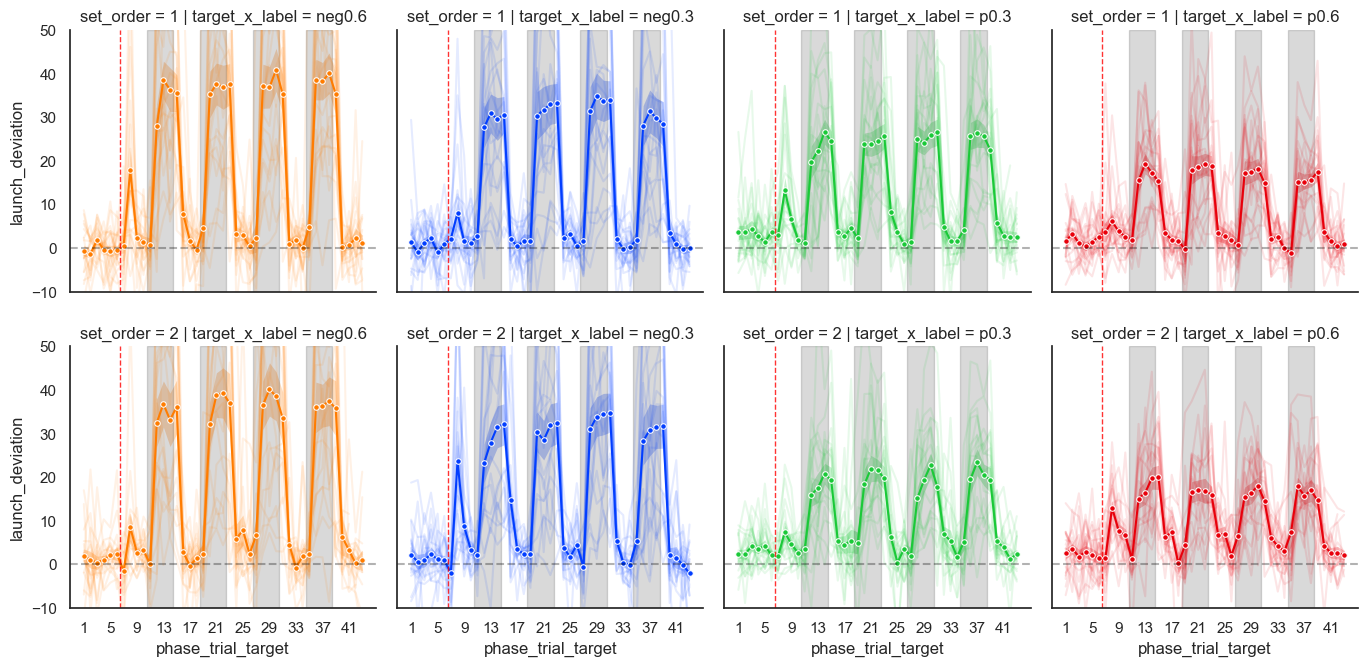

In [641]:
from src.plotting import plot_baseline_washout

plot_baseline_washout(baseline_washout_df,
                      y_col='launch_deviation',
                      show_hits=False
                     )

In [643]:
print(baseline_washout_df['phase_trial_target'].min())
print(baseline_washout_df['phase_trial_target'].max())

1
43


C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, unit_data in sub_data.groupby("units"):
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, unit_data in sub_data.groupby("units"):
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silenc

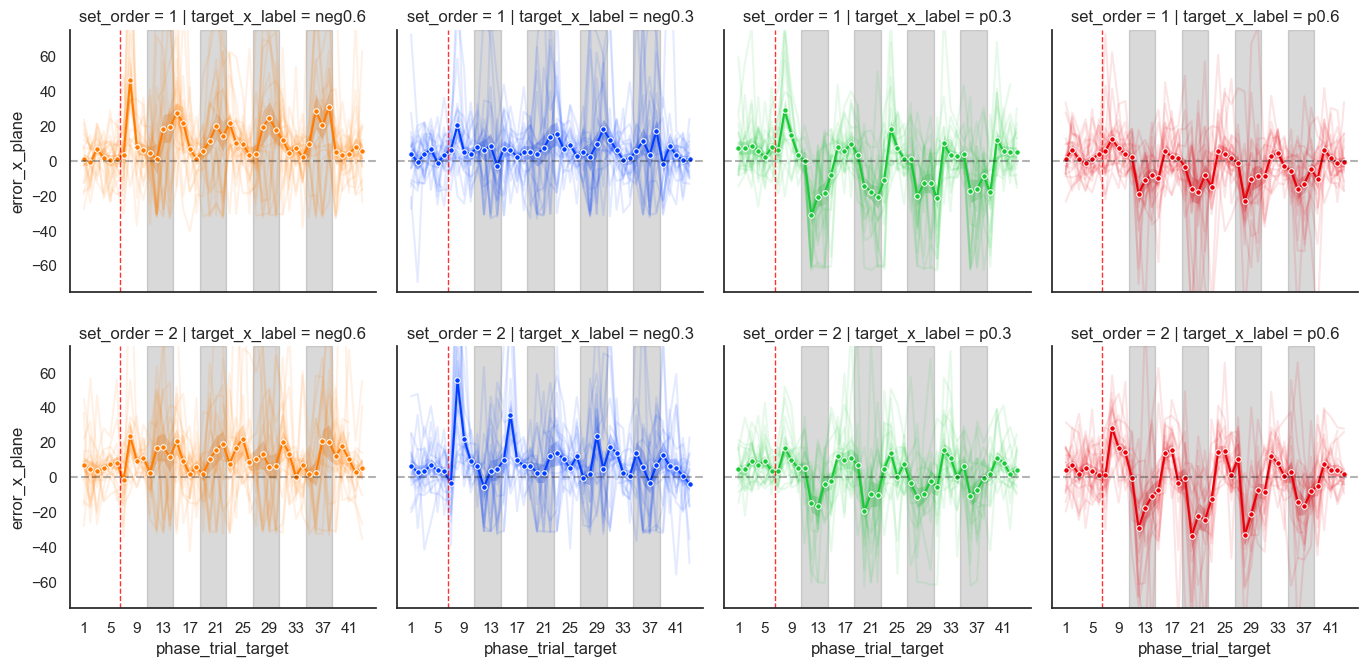

In [645]:
plot_baseline_washout(baseline_washout_df,
                      y_col='error_x_plane',
                      y_lim=(-75,75)
                     )

C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, unit_data in sub_data.groupby("units"):
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, unit_data in sub_data.groupby("units"):
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silenc

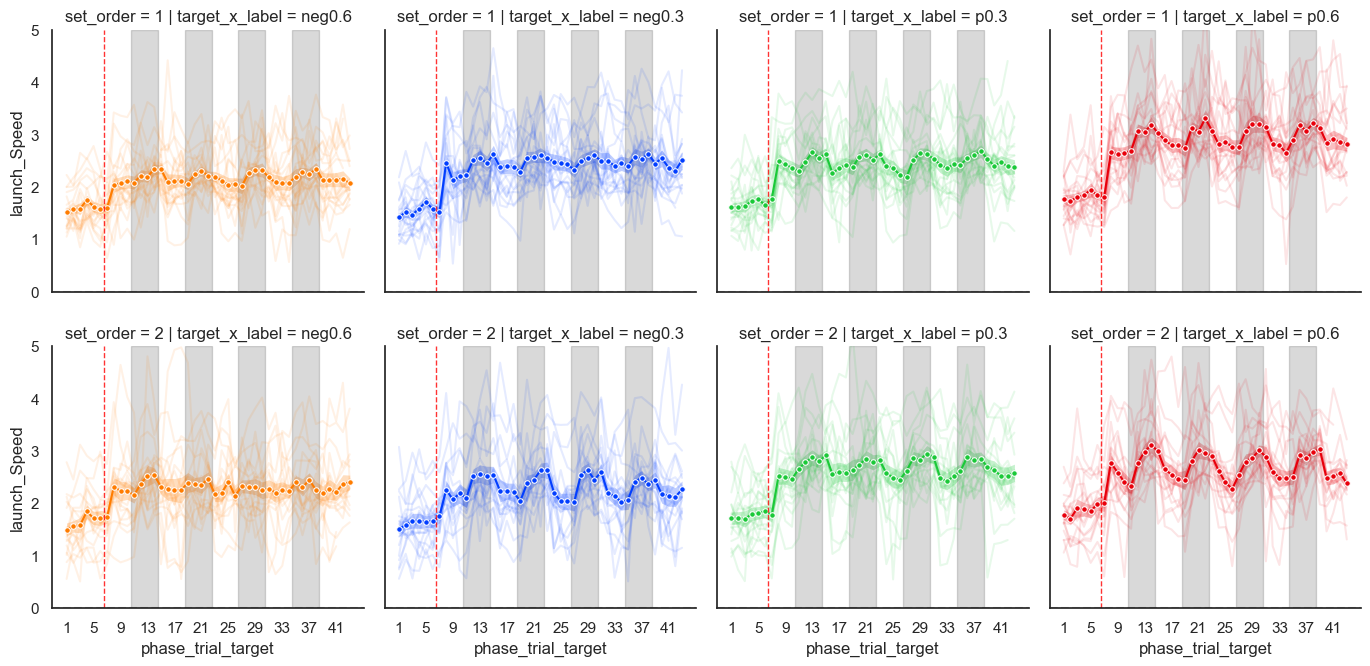

In [657]:
plot_baseline_washout(baseline_washout_df,
                      y_col='launch_Speed',
                      y_lim=(0,5)
                     )

In [649]:
print(baseline_washout_df.groupby(['phase'])['phase_trial_target'].max())
print(baseline_washout_df['phase_trial_target'].min())

phase
baseline       7.0
training_1     NaN
training_2     NaN
washout_1     43.0
washout_2     43.0
Name: phase_trial_target, dtype: float64
1


C:\Users\jacob\AppData\Local\Temp\ipykernel_13620\3425772997.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(baseline_washout_df.groupby(['phase'])['phase_trial_target'].max())


In [286]:
baseline_washout_df_hits = baseline_washout_df[baseline_washout_df['target_hit'] == 'True']
np.unique(baseline_washout_df_hits['target_hit'])

array(['True'], dtype=object)

C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, unit_data in sub_data.groupby("units"):
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, unit_data in sub_data.groupby("units"):
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silenc

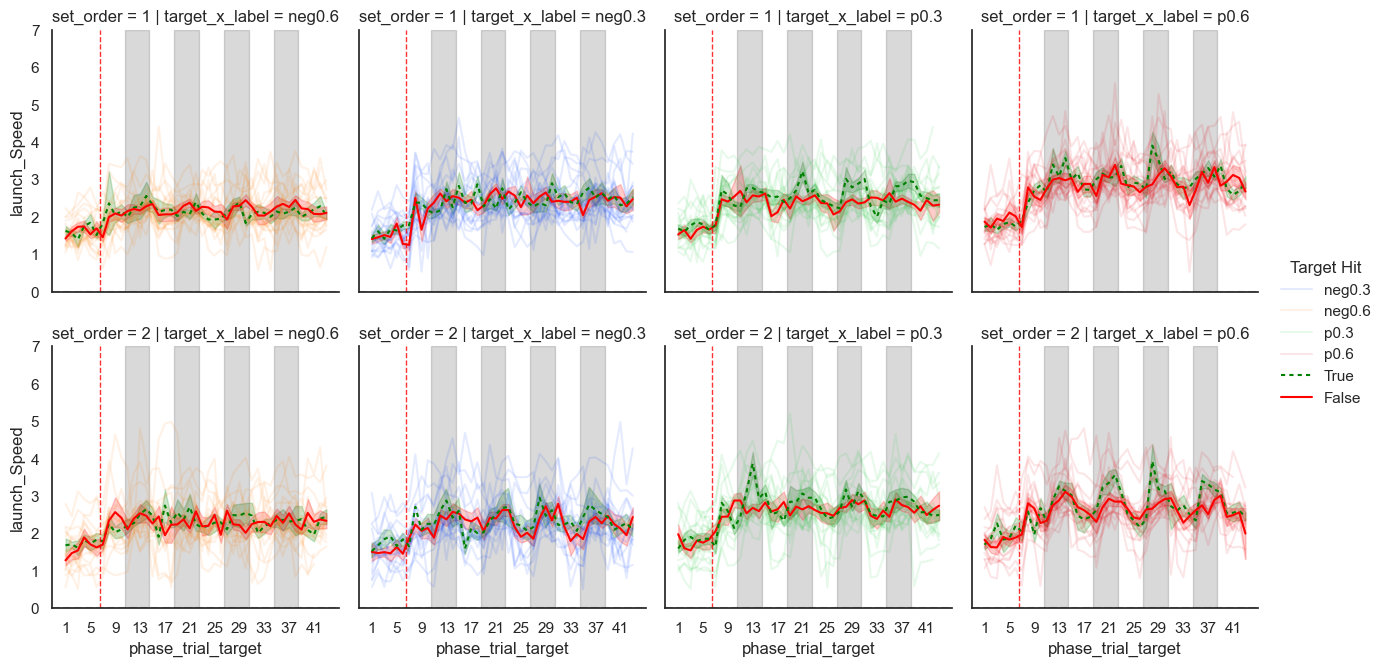

In [651]:
plot_baseline_washout(baseline_washout_df,
                      y_col='launch_Speed',
                      y_lim=(0,7),
                      marker_size=0,
                      show_hits=True
                     )

In [352]:
np.unique(baseline_washout_df['target_hit'])

array(['False', 'True'], dtype=object)

C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, unit_data in sub_data.groupby("units"):
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, unit_data in sub_data.groupby("units"):
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silenc

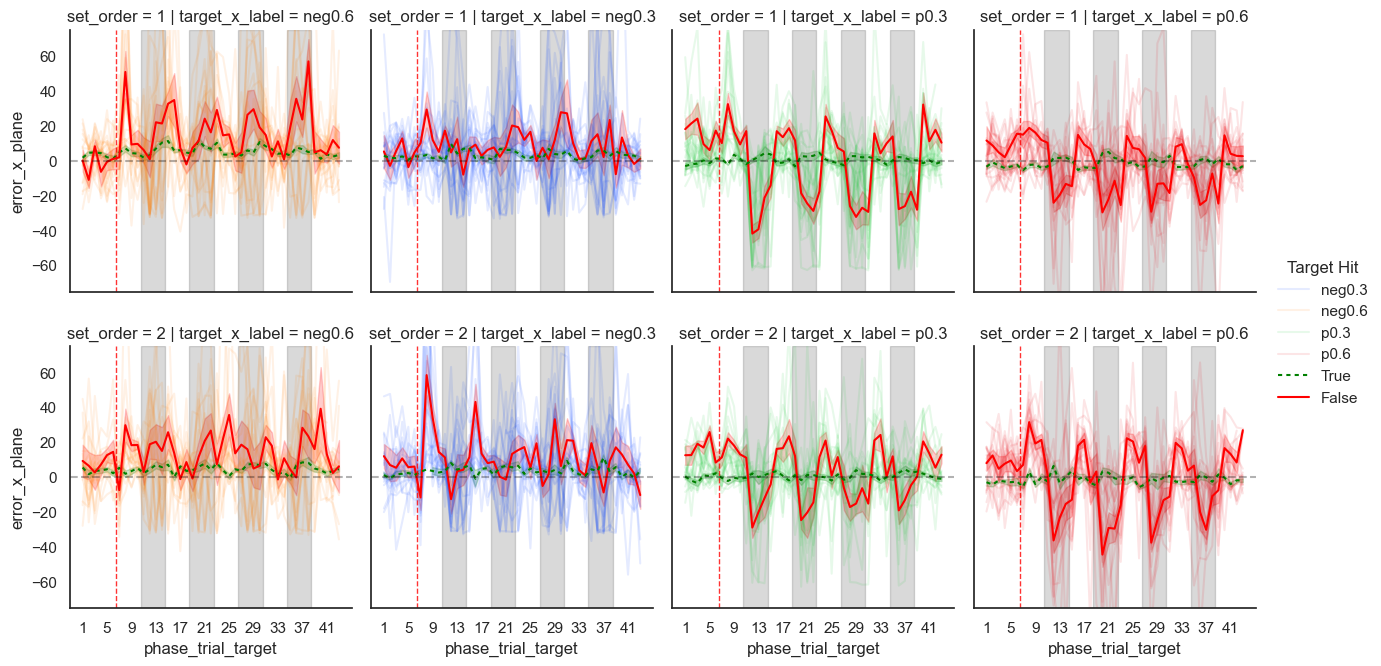

In [653]:
plot_baseline_washout(baseline_washout_df,
                      y_col='error_x_plane',
                      y_lim=(-75,75),
                      marker_size=0,
                      show_hits=True
                     )

In [397]:
baseline_washout_df['launch_deviation'] = -baseline_washout_df['launch_deviation']

In [41]:
# timing
cols = ['step_0_time', 'step_1_time', 'ball_dist_to_center_cm', 'water_speed_binary', 'target_x_label']
df_time = df[cols].copy()

df_time['delta_step_0_1'] = df['step_1_time'] - df['step_0_time']
df_time


step_0_time  step_1_time  ball_dist_to_center_cm water_speed_binary  \
0         32.76032     68.93999               32.167989                  0   
1         72.30322     78.06000               14.809713                  0   
2         82.07687     91.63000               16.184854                  0   
3         96.22158     98.15000                7.246000                  0   
4        101.33090    104.06000                9.792754                  0   
...            ...          ...                     ...                ...   
15851   2285.27800   2285.94000                7.516638                  0   
15852   2288.63300   2289.53000                7.041025                  0   
15853   2292.11400   2293.39000               11.837030                  0   
15854   2296.17900   2297.10000                7.110907                  0   
15855   2299.61700   2300.67000                6.133657                  0   

      target_x_label  delta_step_0_1  
0               p0.3        36.17967  
1               p0.6         5.75678  
2             neg0.6         9.55313  
3             neg0.3         1.92842  
4             neg0.3         2.72910  
...              ...             ...  
15851           p0.3         0.66200  
15852           p0.3         0.89700  
15853         neg0.6         1.27600  
15854         neg0.6         0.92100  
15855           p0.3         1.05300  

[15856 rows x 6 columns]

C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, unit_data in sub_data.groupby("units"):
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, unit_data in sub_data.groupby("units"):
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silenc

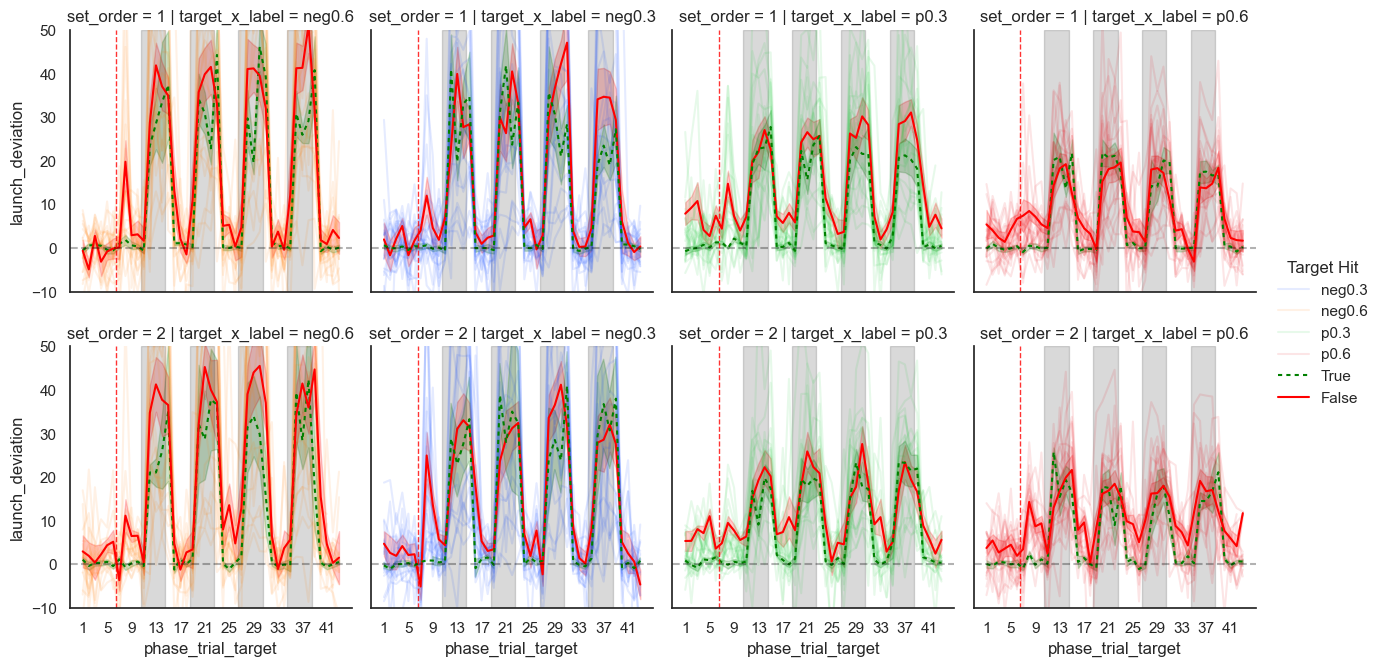

In [655]:
plot_baseline_washout(baseline_washout_df,
                      y_col='launch_deviation',
                      marker_size=0,
                      show_hits=True
                     )

In [ ]:
### AUTOREGRESSIVE MODEL

In [203]:
from src.gamma_AR import gamma_AR

X_sm, y = gamma_AR(df_small_filt, 
         x_cols=['trial_num_target','launch_dev_z','launch_Speed_z'],
         y_col='ball_dist_to_center_cm',
         n_lag=1,
         x_dummys=['set_order','phase','target_x_label','water_speed_binary'],
         interactions=[('launch_dev_z','launch_Speed_z')]
        )


In [207]:

X_sm = X_sm.astype(float)
y = y.astype(float)


In [209]:
X_sm

const  trial_num_target  launch_dev_z  launch_Speed_z  \
0        1.0               7.0      0.889053       -0.796395   
1        1.0               7.0      0.991405       -1.006504   
2        1.0               7.0      0.763261       -0.635638   
3        1.0               8.0      1.696581       -2.010131   
4        1.0               8.0      1.692065       -2.111513   
...      ...               ...           ...             ...   
20932    1.0             122.0      1.331334        1.173733   
20933    1.0             123.0      0.983130        1.707477   
20934    1.0             123.0      0.969851       -0.233114   
20935    1.0             124.0      1.223058        0.382543   
20936    1.0             124.0      0.343235        1.181774   

       ball_dist_to_center_cm_lag1  set__2  phas_training_1  phas_training_2  \
0                         7.635622     0.0              0.0              0.0   
1                        10.945040     0.0              0.0              0.0   
2                         7.327525     0.0              0.0              0.0   
3                        16.738358     0.0              0.0              0.0   
4                        32.096829     0.0              0.0              0.0   
...                            ...     ...              ...              ...   
20932                    20.638861     1.0              0.0              0.0   
20933                    13.375844     1.0              0.0              0.0   
20934                     5.145460     1.0              0.0              0.0   
20935                     7.337979     1.0              0.0              0.0   
20936                     7.570455     1.0              0.0              0.0   

       phas_washout_1  phas_washout_2  targ_neg0.6  targ_p0.3  targ_p0.6  \
0                 0.0             0.0          0.0        0.0        1.0   
1                 0.0             0.0          1.0        0.0        0.0   
2                 0.0             0.0          0.0        1.0        0.0   
3                 0.0             0.0          0.0        0.0        0.0   
4                 0.0             0.0          1.0        0.0        0.0   
...               ...             ...          ...        ...        ...   
20932             0.0             1.0          0.0        1.0        0.0   
20933             0.0             1.0          0.0        1.0        0.0   
20934             0.0             1.0          1.0        0.0        0.0   
20935             0.0             1.0          0.0        1.0        0.0   
20936             0.0             1.0          1.0        0.0        0.0   

       wate_1  launch_dev_z_x_launch_Speed_z  
0         0.0                      -0.708037  
1         0.0                      -0.997853  
2         0.0                      -0.485158  
3         0.0                      -3.410350  
4         0.0                      -3.572818  
...       ...                            ...  
20932     0.0                       1.562631  
20933     0.0                       1.678671  
20934     0.0                      -0.226086  
20935     0.0                       0.467873  
20936     0.0                       0.405626  

[20937 rows x 15 columns]

In [211]:
import statsmodels.api as sm

gamma_model = sm.GLM(
    y,
    X_sm,
    family=sm.families.Gamma(sm.families.links.Log())
)
gamma_res = gamma_model.fit()
print(gamma_res.summary())


                   Generalized Linear Model Regression Results                    
Dep. Variable:     ball_dist_to_center_cm   No. Observations:                20937
Model:                                GLM   Df Residuals:                    20922
Model Family:                       Gamma   Df Model:                           14
Link Function:                        Log   Scale:                         0.55436
Method:                              IRLS   Log-Likelihood:                -95471.
Date:                    Thu, 13 Nov 2025   Deviance:                       14474.
Time:                            15:23:37   Pearson chi2:                 1.16e+04
No. Iterations:                        45   Pseudo R-squ. (CS):             0.4528
Covariance Type:                nonrobust                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------

<Figure size 900x500 with 0 Axes>

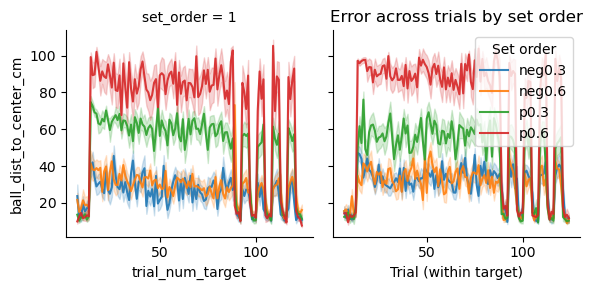

In [187]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(9, 5))

# set facets by target
g = sns.FacetGrid(df_small_filt, 
                    col='set_order', 
                    sharex=True, 
                    sharey=True)

g.map_dataframe(sns.lineplot,
    data=df_small_filt,
    x='trial_num_target',
    y='ball_dist_to_center_cm',
    hue='target_x_label',          
    estimator='mean',
    errorbar='se',
    alpha=0.9
)

plt.xlabel("Trial (within target)")
plt.ylabel("Mean lateral error (cm)")
plt.title("Error across trials by set order")
plt.legend(title="Set order")
plt.tight_layout()
plt.show()


In [237]:
df_pred = df_small_filt.copy()

X_pred, _ = gamma_AR(
    df_pred,
    x_cols=['trial_num_target','launch_dev_z','launch_Speed_z'],
    y_col='ball_dist_to_center_cm',
    n_lag=1,
    x_dummys=['set_order','phase','target_x_label','water_speed_binary'],
    interactions=[('launch_dev_z','launch_Speed_z')]
)

# 1. Align columns
X_pred = X_pred[gamma_res.params.index]

# 2. Convert everything to pure float numpy arrays
Xn   = X_pred.to_numpy(dtype=float)
beta = gamma_res.params.to_numpy(dtype=float)

# 3. Compute linear predictor
eta = Xn @ beta

# 4. Compute predicted values
# remove rows where the lag would be NaN
df_pred = df_pred.iloc[1:].reset_index(drop=True)
df_pred['y_hat'] = np.exp(eta)



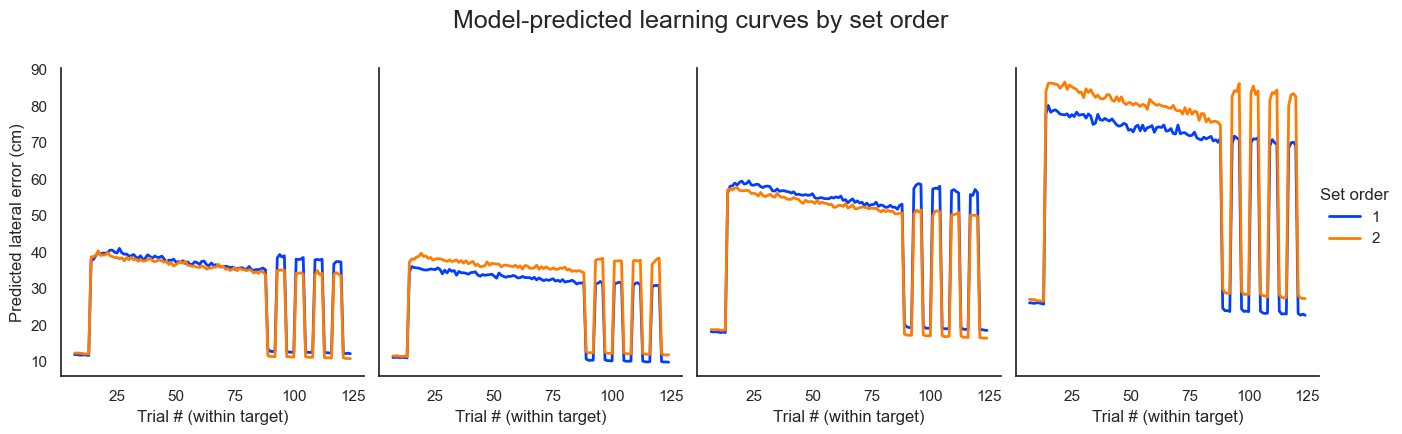

In [253]:
import seaborn as sns
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.pyplot as plt

def plot_predicted_learning_by_set(
    df_pred,
    x_col='trial_num_target',
    y_col='y_hat',
    col='target_x_label',
    hue='set_order',
    col_order=["neg0.6", "neg0.3", "p0.3", "p0.6"],
    context='notebook',
    font_scale=2.5,
):

    sns.set_context(context, font_scale)
    sns.set_theme()
    sns.set_style("white")

    # One row, multiple columns, colour = set_order
    g = sns.FacetGrid(
        df_pred,
        col=col,
        col_order=col_order,
        sharey=True,
        sharex=True,
        height=4
    )

    g.set_titles("")  # clean
    g.map_dataframe(
        sns.lineplot,
        x=x_col,
        y=y_col,
        hue=hue,
        estimator='mean',
        errorbar=None,
        lw=2,
        alpha=1,
        palette='bright'
    )

    # Unify legend across facets
    g.add_legend(title="Set order")

    g.set_axis_labels("Trial # (within target)", "Predicted lateral error (cm)")

    g.fig.subplots_adjust(top=0.85)
    g.fig.suptitle("Model-predicted learning curves by set order", fontsize=18)

    g.fig.set_size_inches(14, 4.5)

    plt.show()

    return g


plot_predicted_learning_by_set(df_pred)



In [227]:
print(df_small_filt.columns)


Index(['ppid', 'trial_num', 'phase', 'trial_num_target', 'launch_deviation',
       'launch_dev_z', 'launch_Speed', 'launch_Speed_z',
       'ball_dist_to_center_cm', 'target_hit', 'water_speed_binary',
       'water_speed_m_s', 'target_x_label', 'sign_label', 'set_order',
       'ball_pos_x', 'ball_pos_z', 'target_position_x', 'target_position_z',
       'target_angle_90', 'error_x_plane'],
      dtype='object')
